# Imports


In [1]:
# standard imports
import numpy as np
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# models
import wine_visuals
import a_models
import cluster
# split
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
# stats
from scipy import stats
#warnings
import warnings
warnings.filterwarnings('ignore')

# Acquire/ Prep

In [2]:
df = a_models.import_dataframes('winequality-red.csv', 'winequality-white.csv')
df.head()

Value count of the red wine dataframe: 1599
__________________________________________________
Value count of the white wine dataframe: 4898
__________________________________________________
Value count of the combined dataframes: 6497
__________________________________________________
The value count of the combined dataframes equal the value counts of red + white: True
__________________________________________________
__________________________________________________
Data Frame: 
|                      | 0      | 1      |
|:---------------------|:-------|:-------|
| fixed acidity        | 7.4    | 7.8    |
| volatile acidity     | 0.7    | 0.88   |
| citric acid          | 0.0    | 0.0    |
| residual sugar       | 1.9    | 2.6    |
| chlorides            | 0.076  | 0.098  |
| free sulfur dioxide  | 11.0   | 25.0   |
| total sulfur dioxide | 34.0   | 67.0   |
| density              | 0.9978 | 0.9968 |
| pH                   | 3.51   | 3.2    |
| sulphates            | 0.56   | 0.6

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality type  
0      9.4        5  red  
1      9.8        5  red  
2      9.8        5  red  
3      9.8        6  red  
4      9.4        5  red

##### Take aways

- need to change column names into snakecase
- change quality to a float

# Explore

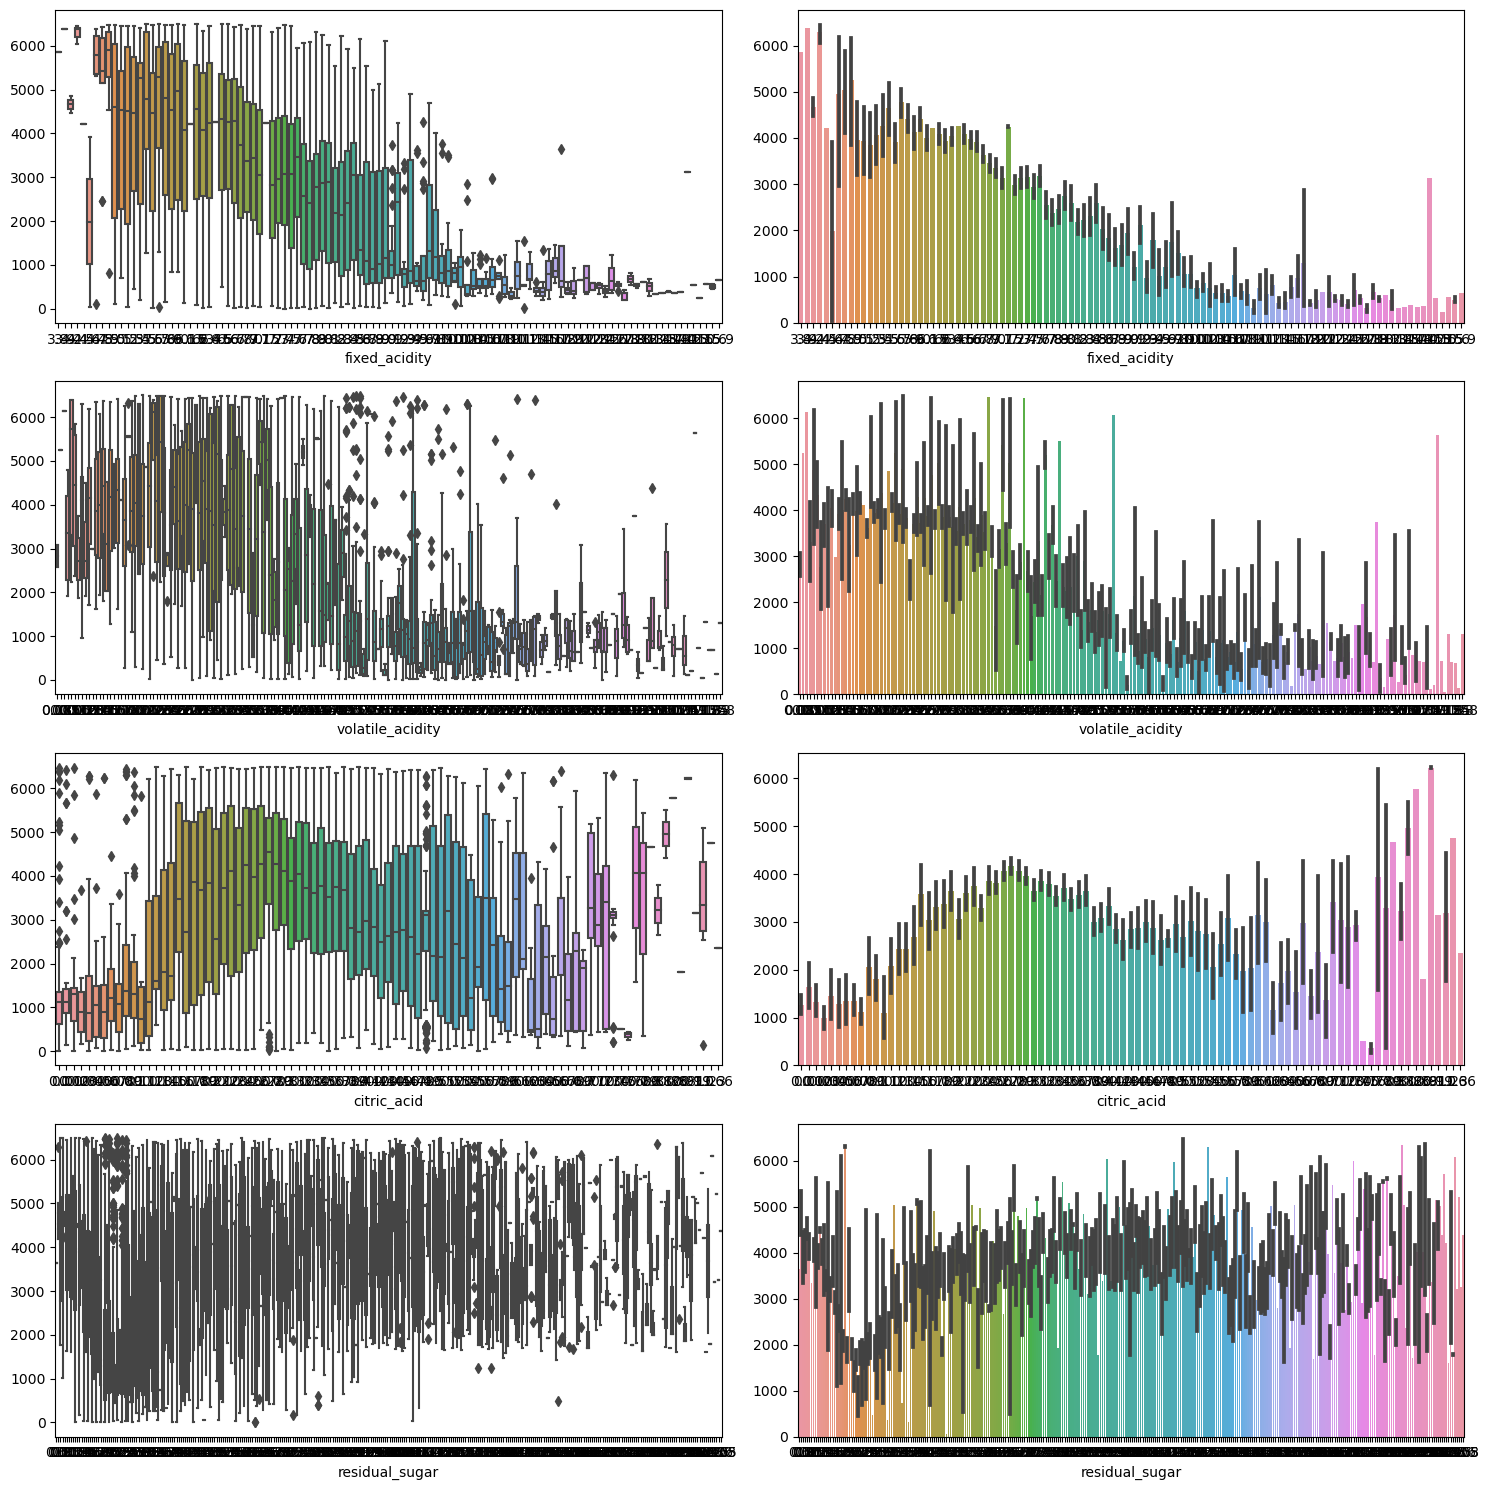

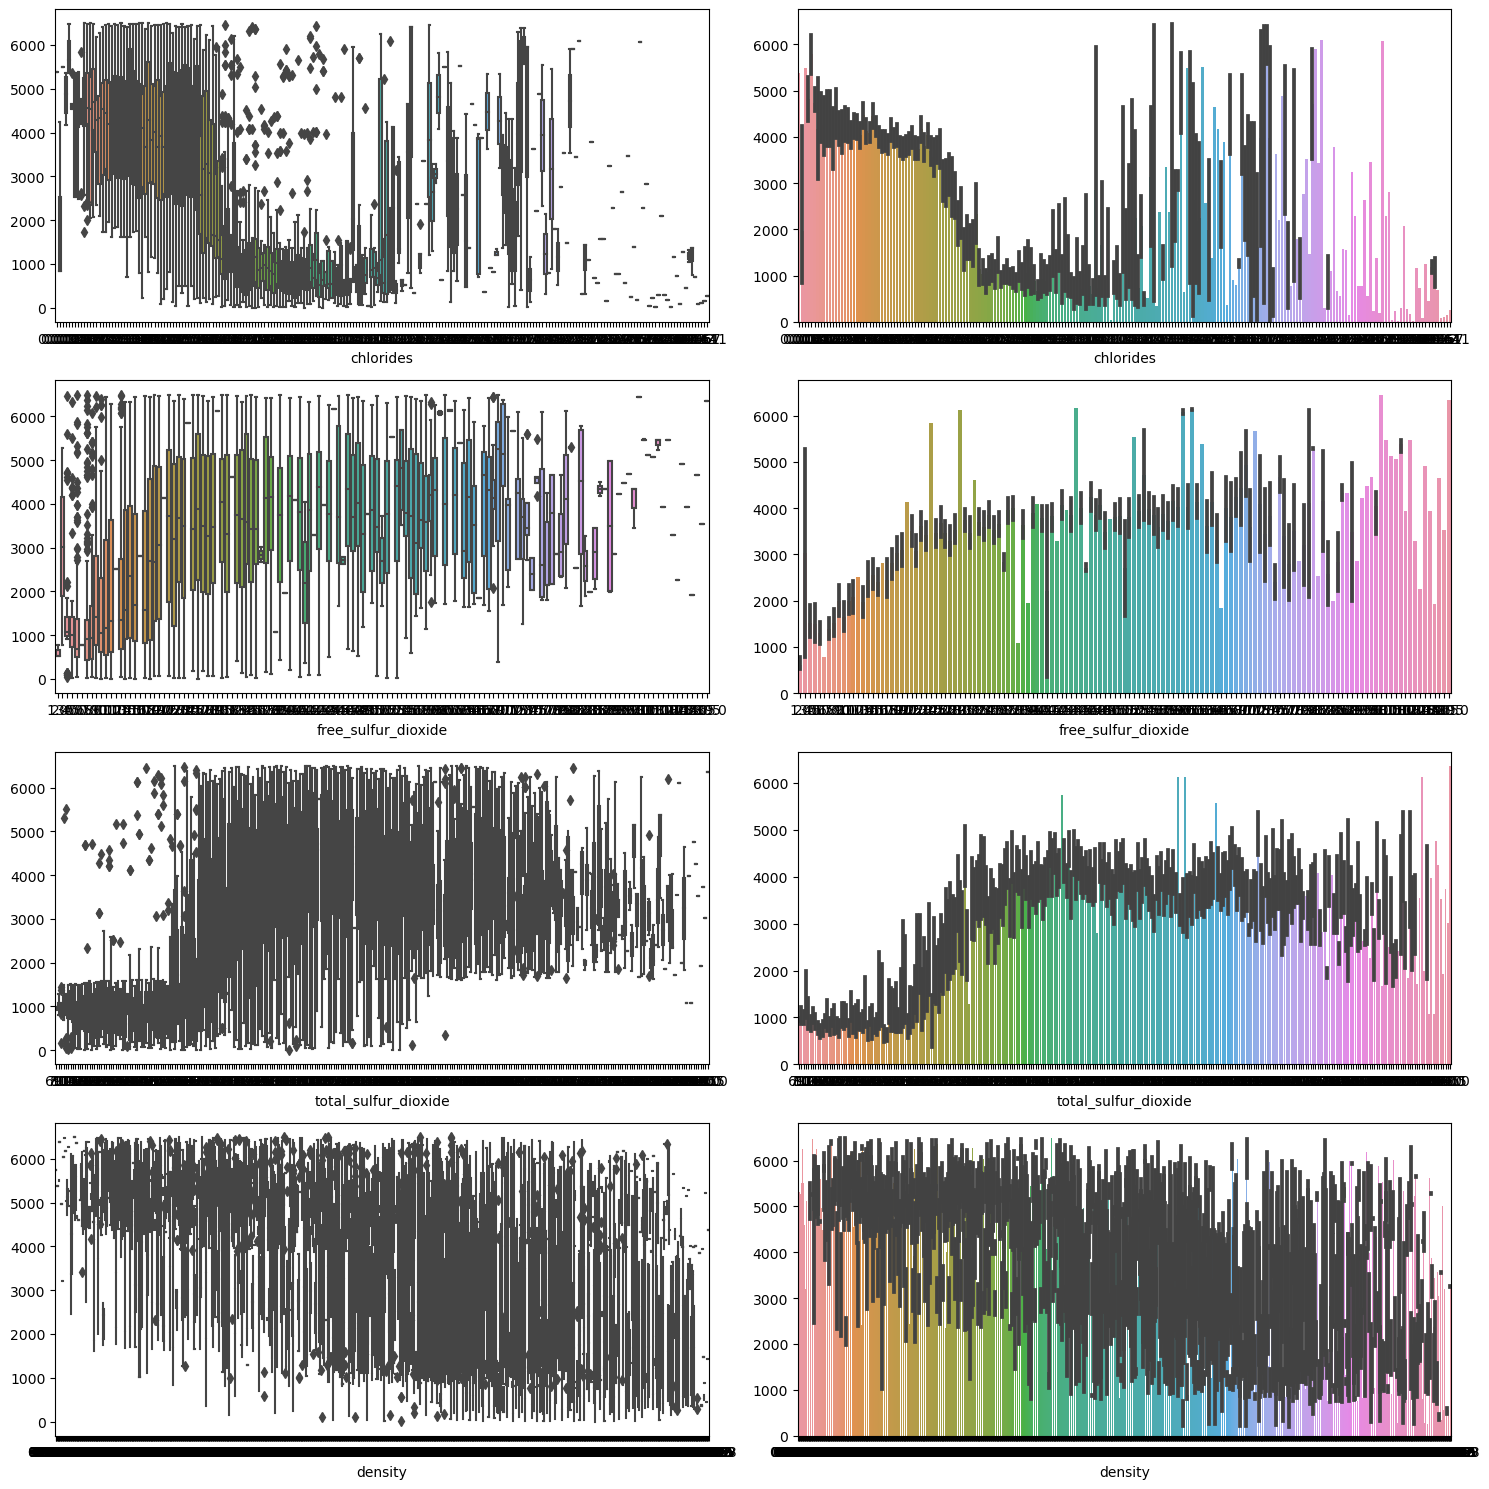

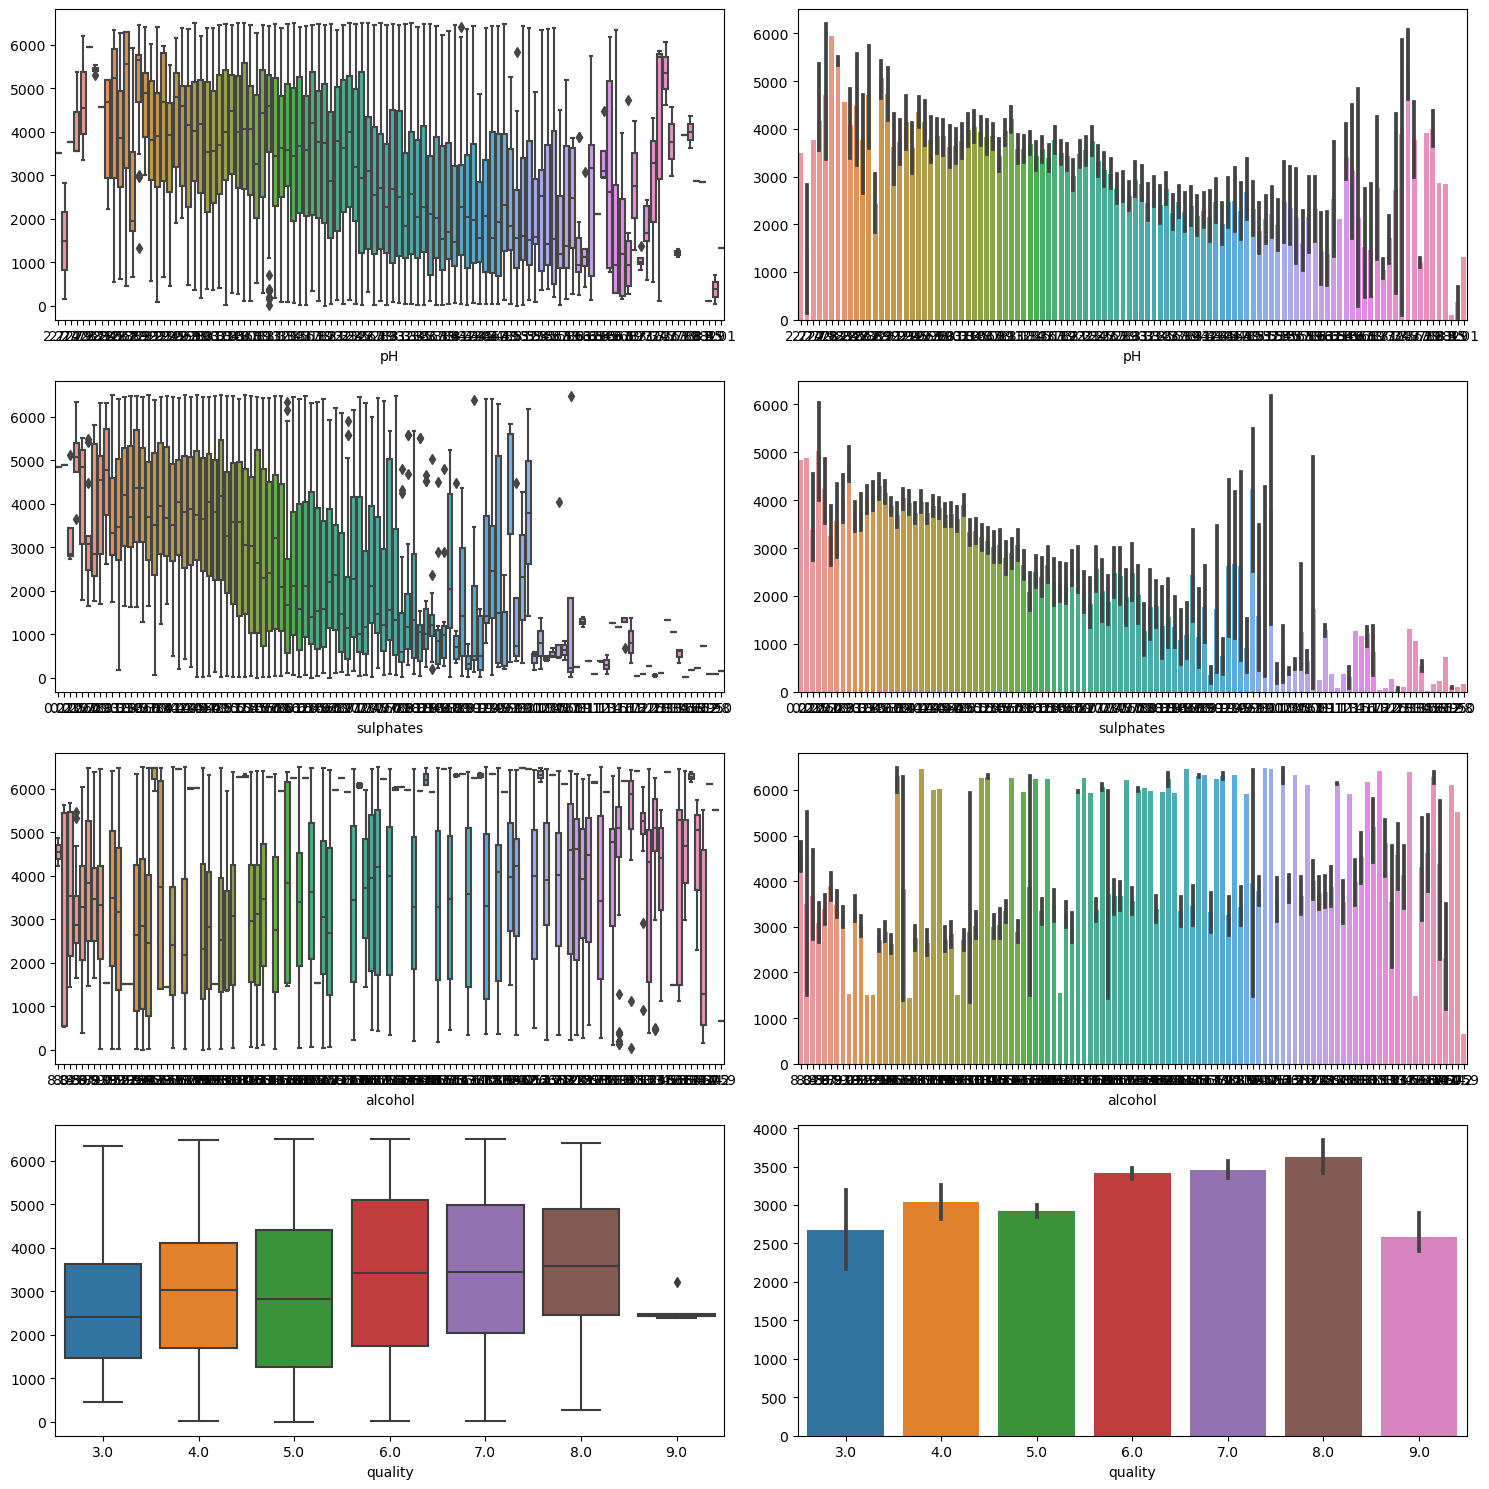

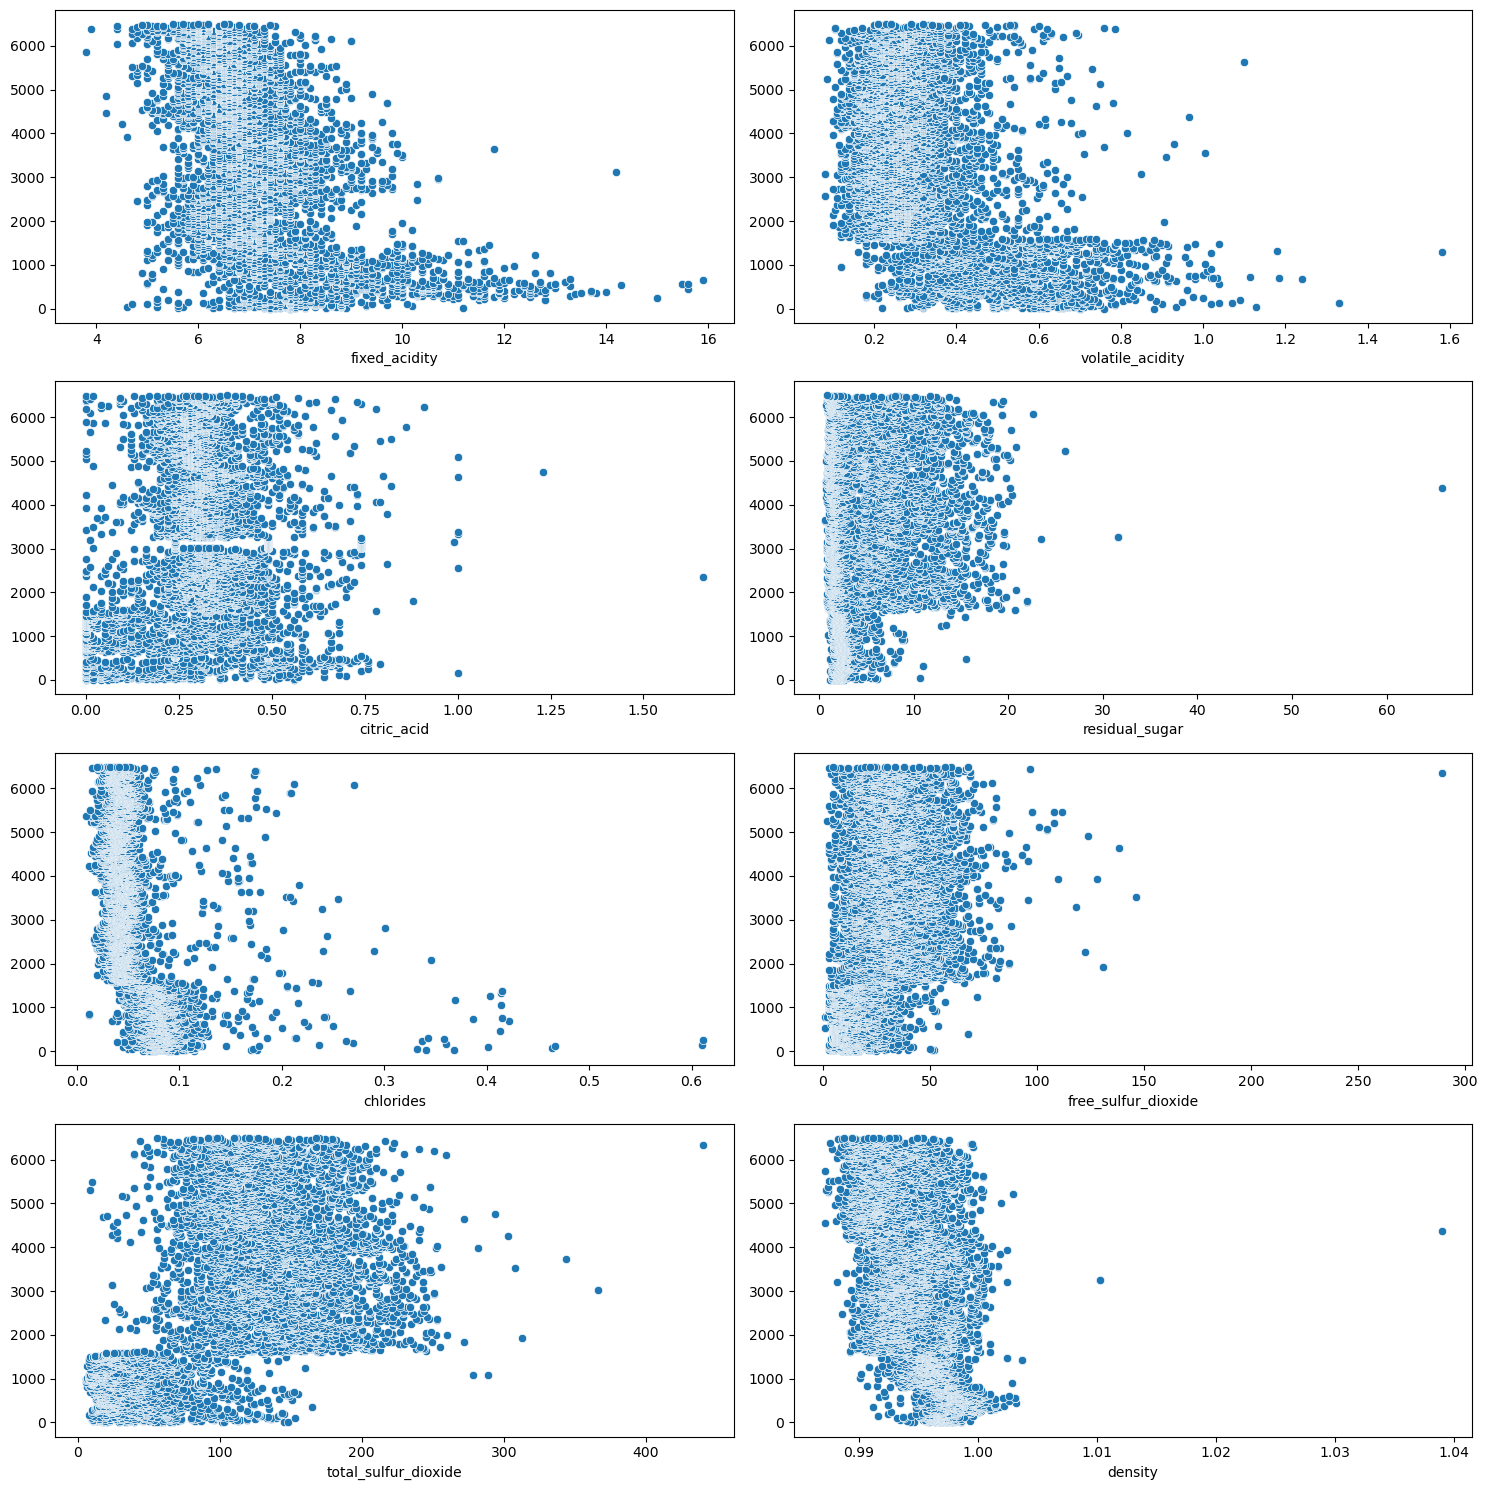

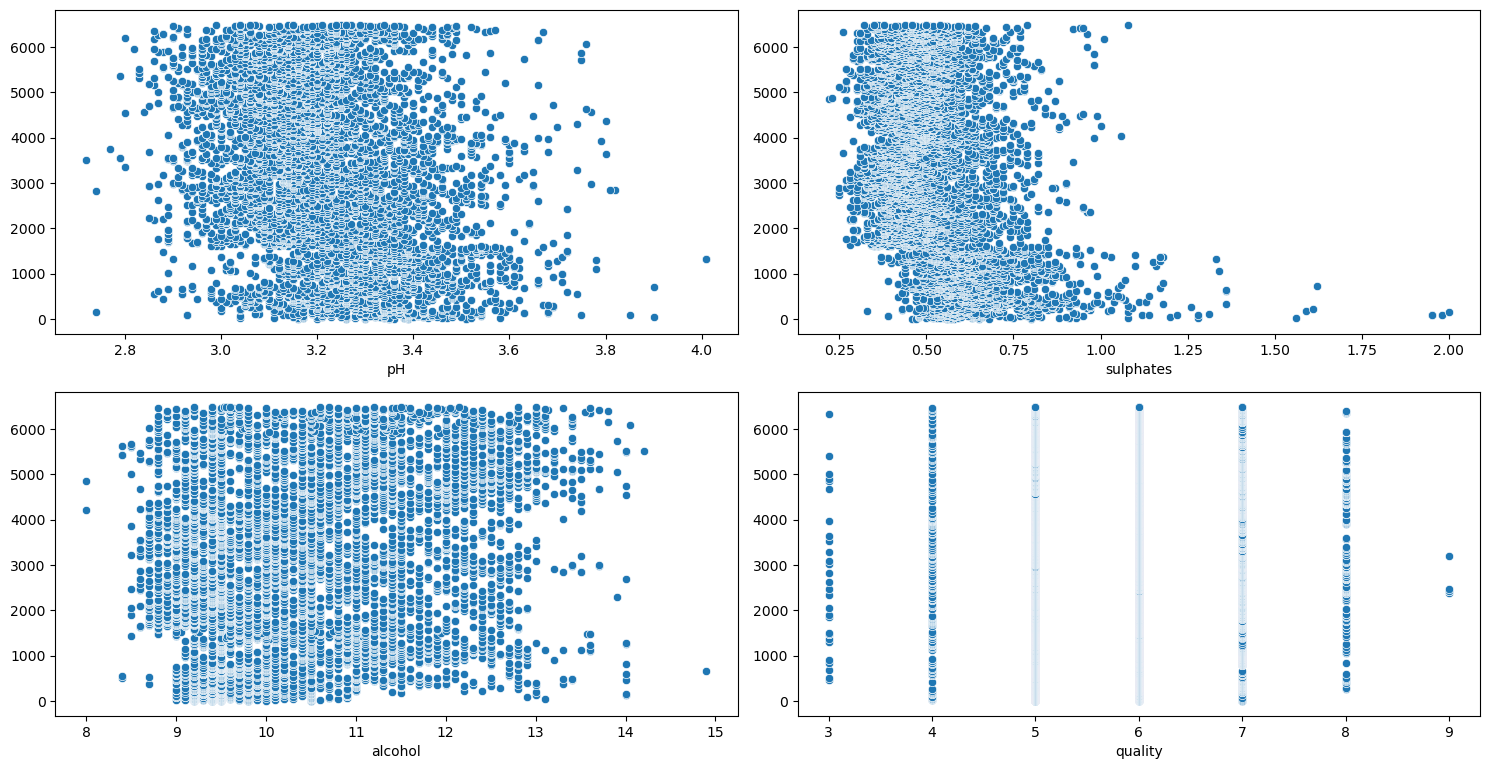

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
2099            7.2             0.280         0.54            16.7      0.045   
3941            7.7             0.400         0.27             4.5      0.034   
3840            7.1             0.280         0.19             7.8      0.040   
24              6.9             0.400         0.14             2.4      0.085   
2541            5.4             0.415         0.19             1.6      0.039   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
2099                 54.0                 200.0  0.99900  3.08       0.49   
3941                 27.0                  95.0  0.99175  3.21       0.59   
3840                 48.0                 184.0  0.99579  3.16       0.50   
24                   21.0                  40.0  0.99680  3.43       0.63   
2541                 27.0                  88.0  0.99265  3.54       0.41   

      alcohol  quality   type  quality_bins  
2099      9.5      6.0  white   mid_quality  
3941     12.3      8.0  white  high_quality  
3840      9.4      5.0  white   low_quality  
24        9.7      6.0    red   mid_quality  
2541     10.0      7.0  white   mid_quality

In [3]:
df, vis, train, val, test = a_models.clean_data(df)
train.head()

### Does alcohol effect wine quality?

H$_0$: There is no relation between alcohol and wine quality.

H$_a$: There is a relation between alcohol and wine quality.

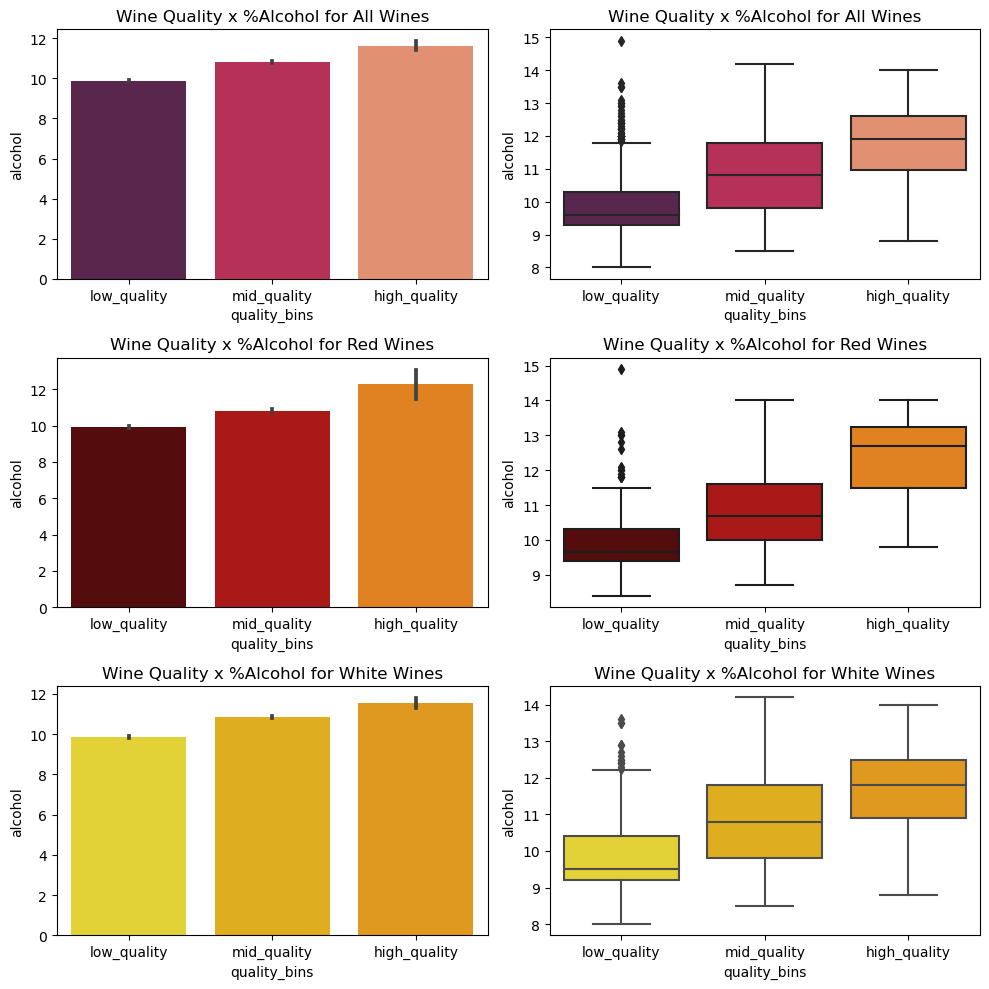

In [4]:
wine_visuals.qual_x_alc(train)

##### Take aways
- outliers in low quality.
- High quality wine tends to contain more alcohol

In [5]:
print('Chi2 performed on % Alcohol x Wine Quality Bins')
print('-'*50)
print(f'\nAll Wine')
print('-'*8)
print(a_models.hyp_chi2(train, 'alcohol', 'quality_bins'))
print('='*50)
print(f'\nRed Wine')
print('-'*8)
print(a_models.hyp_chi2(train[train['type']=='red'], 'alcohol', 'quality_bins'))
print('='*50)
print(f'\nWhite Wine')
print('-'*8)
print(a_models.hyp_chi2(train[train['type']=='white'], 'alcohol', 'quality_bins'))


Chi2 performed on % Alcohol x Wine Quality Bins
--------------------------------------------------

All Wine
--------
We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between alcohol and quality_bins.
None

Red Wine
--------
We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between alcohol and quality_bins.
None

White Wine
--------
We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between alcohol and quality_bins.
None


#### Take aways

% alcohol is a significant trait of wine quality. Specifically it is a significant trait for both red and white wine quality.

### How does residual sugar affect quality?

H$_0$: There is no relation between residual sugar and wine quality.

H$_a$: There is a relation between residual sugar and wine quality.

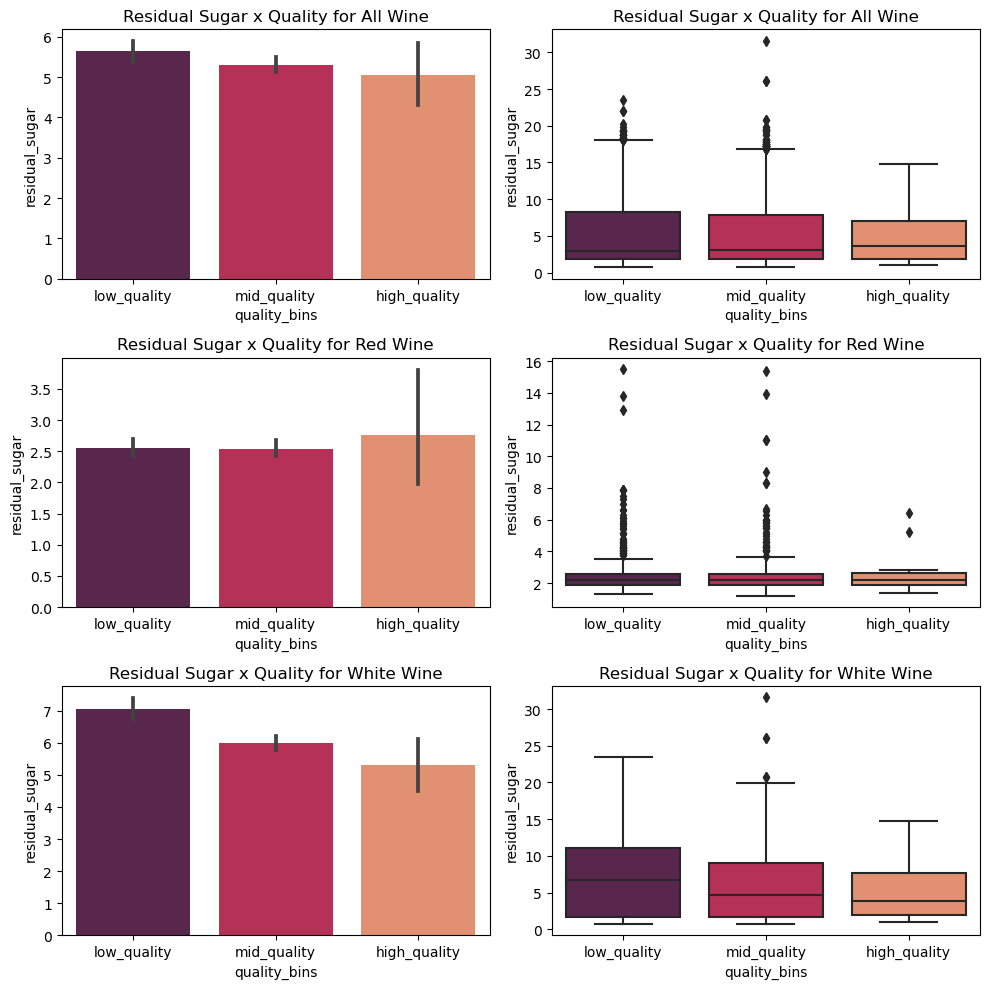

 Min Residual Sugar Value: 0.7
 Max Residual Sugar Value: 31.6


In [6]:
wine_visuals.qual_x_rs(train)

##### Take aways
- lots of outliers
- high quality wines tend to have lower levels of residual sugar, while low quality wines have higher levels of residual sugar
- Something is going on with red wine.
    - Why so many outliers?

In [7]:
# bin residual sugar for classification use
train['rs_bins'] = pd.cut(train.residual_sugar,[0,20,40,60,80]
                           , labels=['under_20'
                                     , '20_to_40_including40'
                                     , '40_to_60_including60'
                                     , '60_to_80_including80'])
#train.head()

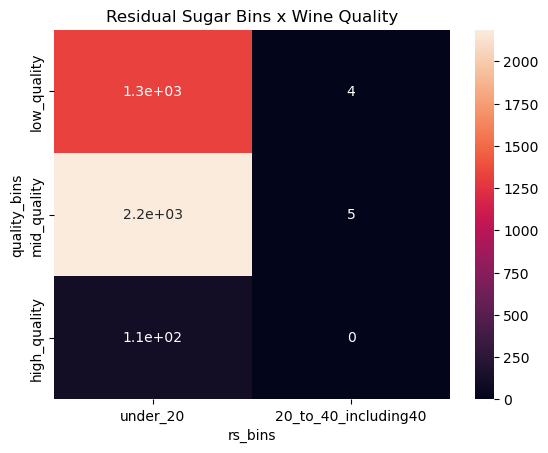

In [8]:
# create cross tab of residual sugar bins against wine quality bins
observed = pd.crosstab(train.quality_bins, train.rs_bins)
# create heatmap of residual sugar bins against wine quality bins
plt.title('Residual Sugar Bins x Wine Quality')
sns.heatmap(data=observed, annot=True)
plt.show()

##### Take aways

I binned residual sugar data into 'under_20', '20_to_40_including40', '40_to_60_including60', '60_to_80_including80'. 

I then crosstabed these bins against wine quality, and created a heat map. 

The heatmap showed 10 values out of more than 3500 values, were greater than 20. Because of the insignificant amount of residual sugar values above 20, I decided to drop those values from the dataset.

Curious if those high residual sugar values have a relation to the type of wine and it's quality?

In [9]:
def remove_high_rs(df):
    '''This function removes values with residual sugar values above 20'''
    mask = df['residual_sugar'] <= 20
    df = df[mask]
    return df
# reassign train to remove values with residual sugar values above 20
train = remove_high_rs(train)
# identify residual sugar range
print(f' Min Residual Sugar Value: {train.residual_sugar.min()}')
print(f' Max Residual Sugar Value: {train.residual_sugar.max()}')

 Min Residual Sugar Value: 0.7
 Max Residual Sugar Value: 19.9


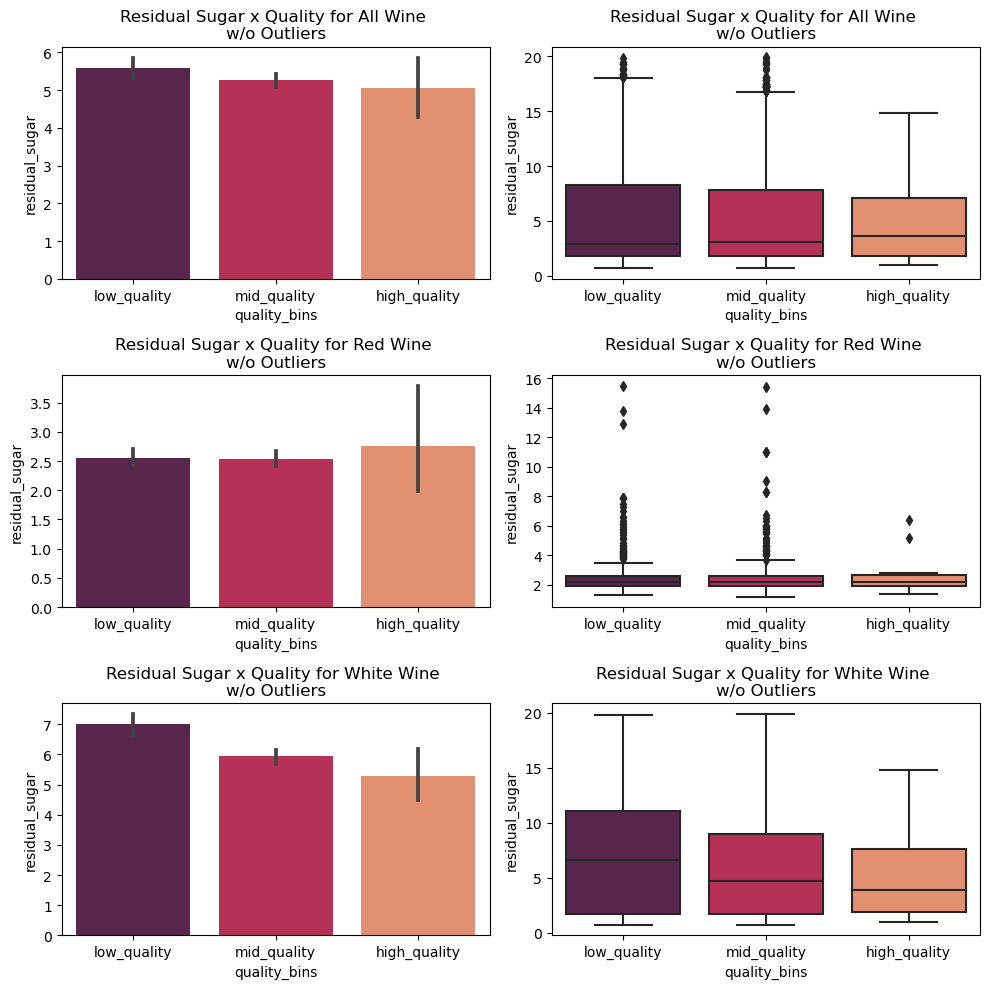

In [10]:
wine_visuals.qual_x_rs_wo_outliers(train)

In [11]:
# re - bin residual sugar for classification use
train['rs_bins2'] = pd.cut(train.residual_sugar,[0,5,10,15,20]
                           , labels=['5_and_under'
                                     , '5_to_10'
                                     , '10_to_15'
                                     , '15_to_20'])

In [12]:
# create cross tab of residual sugar bins against wine quality bins
observed_all = pd.crosstab(train.quality_bins, train.rs_bins2)
# set alpha
α = 0.05
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed_all)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between wine quality and residual sugar.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between wine quality and residual sugar')

We reject the null hypothesis. With p value: 0.0043, there is enough evidence to support a statistical relationship between wine quality and residual sugar.


In [13]:
# hypothesis test for red wine quality x residual sugar
# red wine cross tab
observed_red = pd.crosstab(train[train['type']=='red'].quality_bins, train[train['type']=='red'].rs_bins2)
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed_red)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between red wine quality and residual sugar.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between red wine quality and residual sugar')

We fail to reject the null hypothesis. With p value: 0.5223, this is not enough evidence to support a statistical relationship between red wine quality and residual sugar


In [14]:
# white wine crosstab
observed_w = pd.crosstab(train[train['type']=='white'].quality_bins, train[train['type']=='white'].rs_bins2)
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed_w)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between white wine quality and residual sugar.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between white wine quality and residual sugar')

We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between white wine quality and residual sugar.


##### Take aways
Wine in general has a significant relationship between quality and residual sugar. White wine also has a significant relationship to quality and residual sugar, however red wine does not.

##### How does pH and free sulfur dioxide relate to quality?

H$_0$: There is no relation between pH, sulfer dioxide and wine quality.

H$_a$: There is a relation between pH, sulfer dioxide and wine quality.

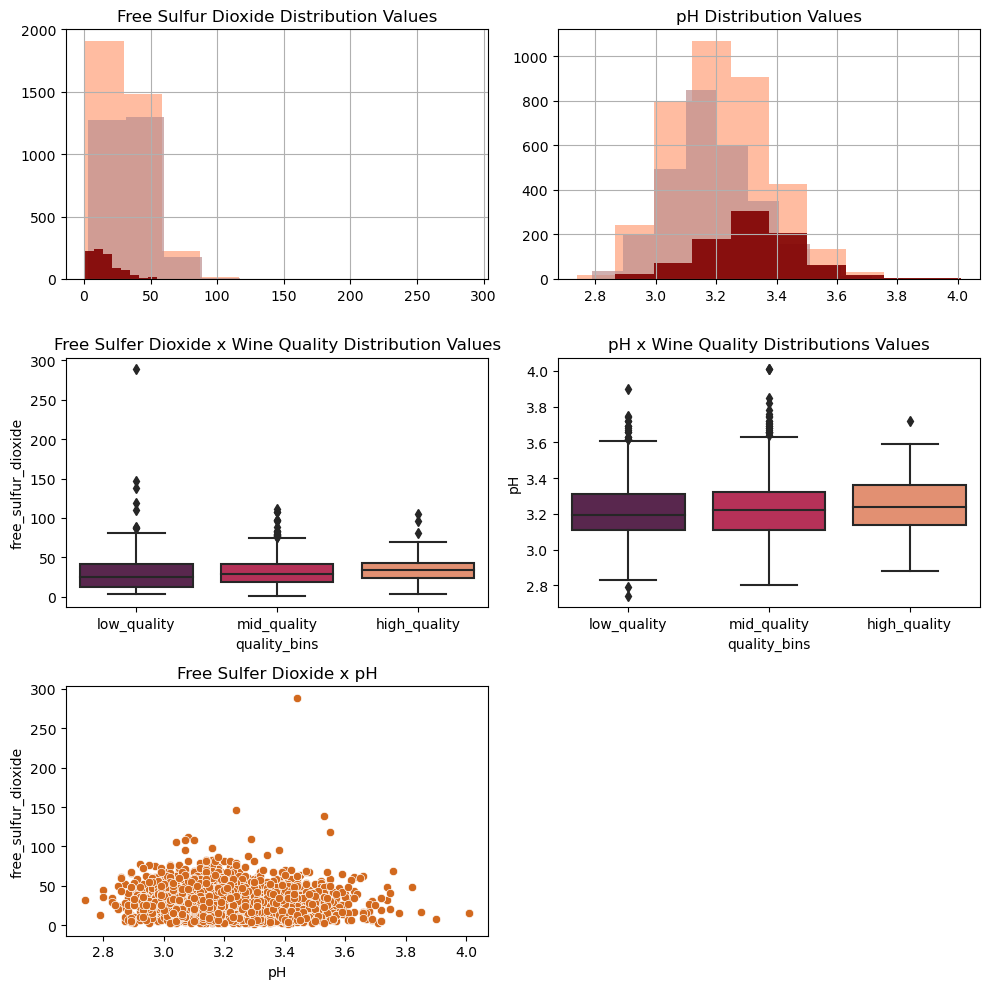

Free Sulfur Dioxide Min Value: 1.0
Free Sulfur Dioxide Max Value: 289.0
--------------------------------------------------
pH Min Value: 2.74
pH Max Value: 4.01


In [15]:
wine_visuals.fsd_x_ph(train)

In [16]:
# view the largest values for free sulfur dioxide
# determine if the outlier can be dropped
train.sort_values(by='free_sulfur_dioxide',ascending=False).head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
6344            6.1             0.260         0.25             2.9      0.047   
3530            7.1             0.490         0.22             2.0      0.047   
4649            6.2             0.255         0.24             1.7      0.039   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
6344                289.0                 440.0  0.99314  3.44       0.64   
3530                146.5                 307.5  0.99240  3.24       0.37   
4649                138.5                 272.0  0.99452  3.53       0.53   

      alcohol  quality   type quality_bins   rs_bins     rs_bins2  
6344     10.5      3.0  white  low_quality  under_20  5_and_under  
3530     11.0      3.0  white  low_quality  under_20  5_and_under  
4649      9.6      4.0  white  low_quality  under_20  5_and_under

##### Take aways
There is only one free_sulfur_dioxide value above 150 at 289. I will treat this as an outlier and will remove this value from the dataset.

In [17]:
def remove_high_sd(df):
    '''This function removes free sulfur dioxide values above 150'''
    mask = df['free_sulfur_dioxide'] < 150
    df = df[mask]
    return df

# reassign train to remove outlier
train = remove_high_sd(train)

# verify outlier has been dropped
train.sort_values(by='free_sulfur_dioxide',ascending=False).head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3530            7.1             0.490         0.22            2.00      0.047   
4649            6.2             0.255         0.24            1.70      0.039   
3287            6.7             0.250         0.26            1.55      0.041   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
3530                146.5                 307.5  0.99240  3.24       0.37   
4649                138.5                 272.0  0.99452  3.53       0.53   
3287                118.5                 216.0  0.99490  3.55       0.63   

      alcohol  quality   type quality_bins   rs_bins     rs_bins2  
3530     11.0      3.0  white  low_quality  under_20  5_and_under  
4649      9.6      4.0  white  low_quality  under_20  5_and_under  
3287      9.4      3.0  white  low_quality  under_20  5_and_under

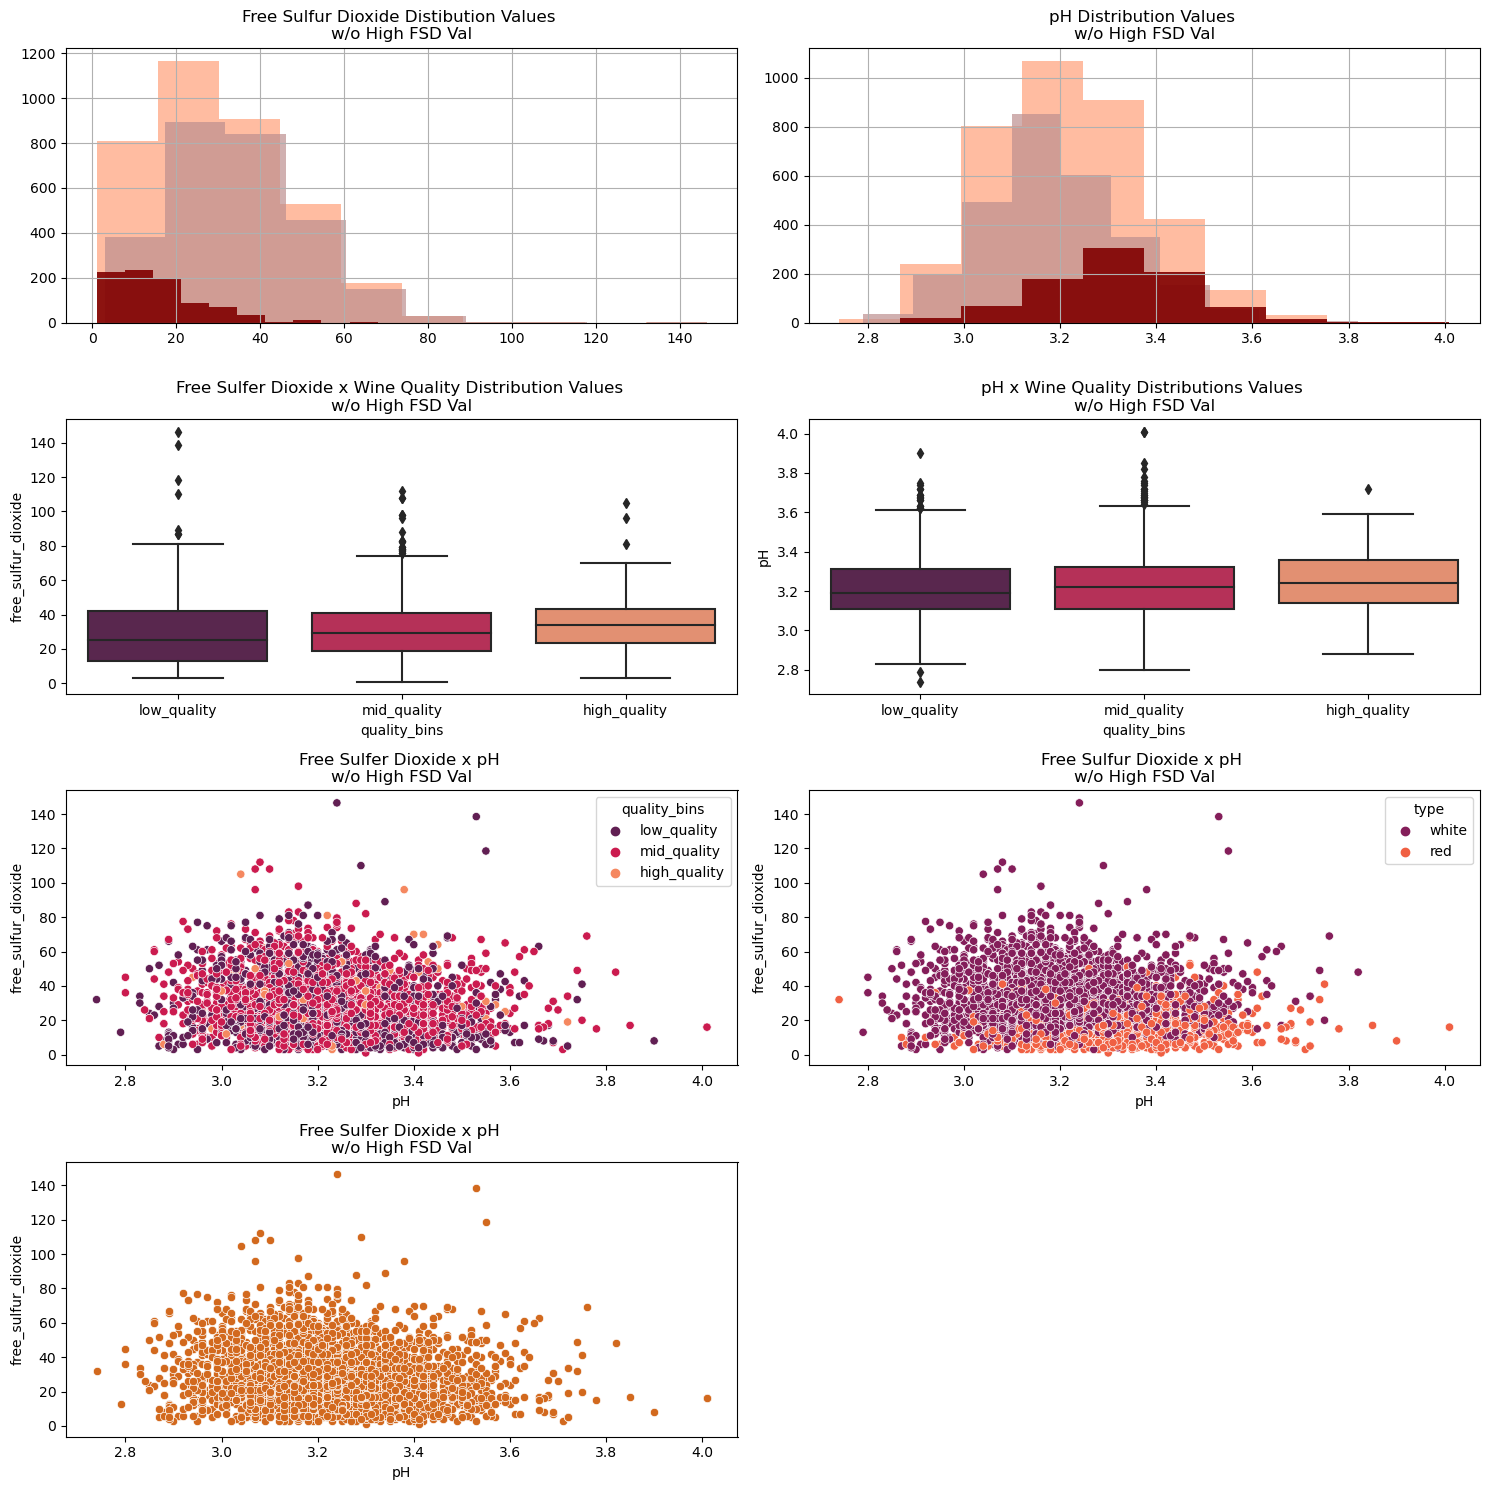

Free Sulfur Dioxide Min Value: 1.0
Free Sulfur Dioxide Max Value: 146.5
--------------------------------------------------
pH Min Value: 2.74
pH Max Value: 4.01


In [18]:
wine_visuals.fsd_x_ph_wo_fsd_outlier(train)

##### Take aways
- Free sulfur dioxide seems to have right skew
- pH look approx. normal
    - red wine seems to have the largest mean pH, white wine the smallest
- lots of outliers outliers
- White wine appears to have a greater free sulfur dioxide value
- Red wine appears to have a smaller free sulfur dioxide value and possibly a larger pH
- It looks like high quality wine tends to have a larger pH and lower sulfer dioxide distribution than mid and low quality wine.
- Low quality wine seems to vary more in free sulfur dioxide while mid quality wine seems to vary more in pH

In [19]:
def remove_outliers(df):
    '''This function removes outliers from specified columns using interquartile range'''
    columns = ["free_sulfur_dioxide"
               , "pH"]
    for col in columns:
    # setting floor for my data
        Q1 = df[col].quantile(0.25)
    # setting ceiling for my data
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        floor = Q1 - 1.5 * IQR
        ceiling = Q3 + 1.5 * IQR
        df = df.loc[(df[col] >= floor) & (df[col] <= ceiling)]
    return df
train = remove_outliers(train)

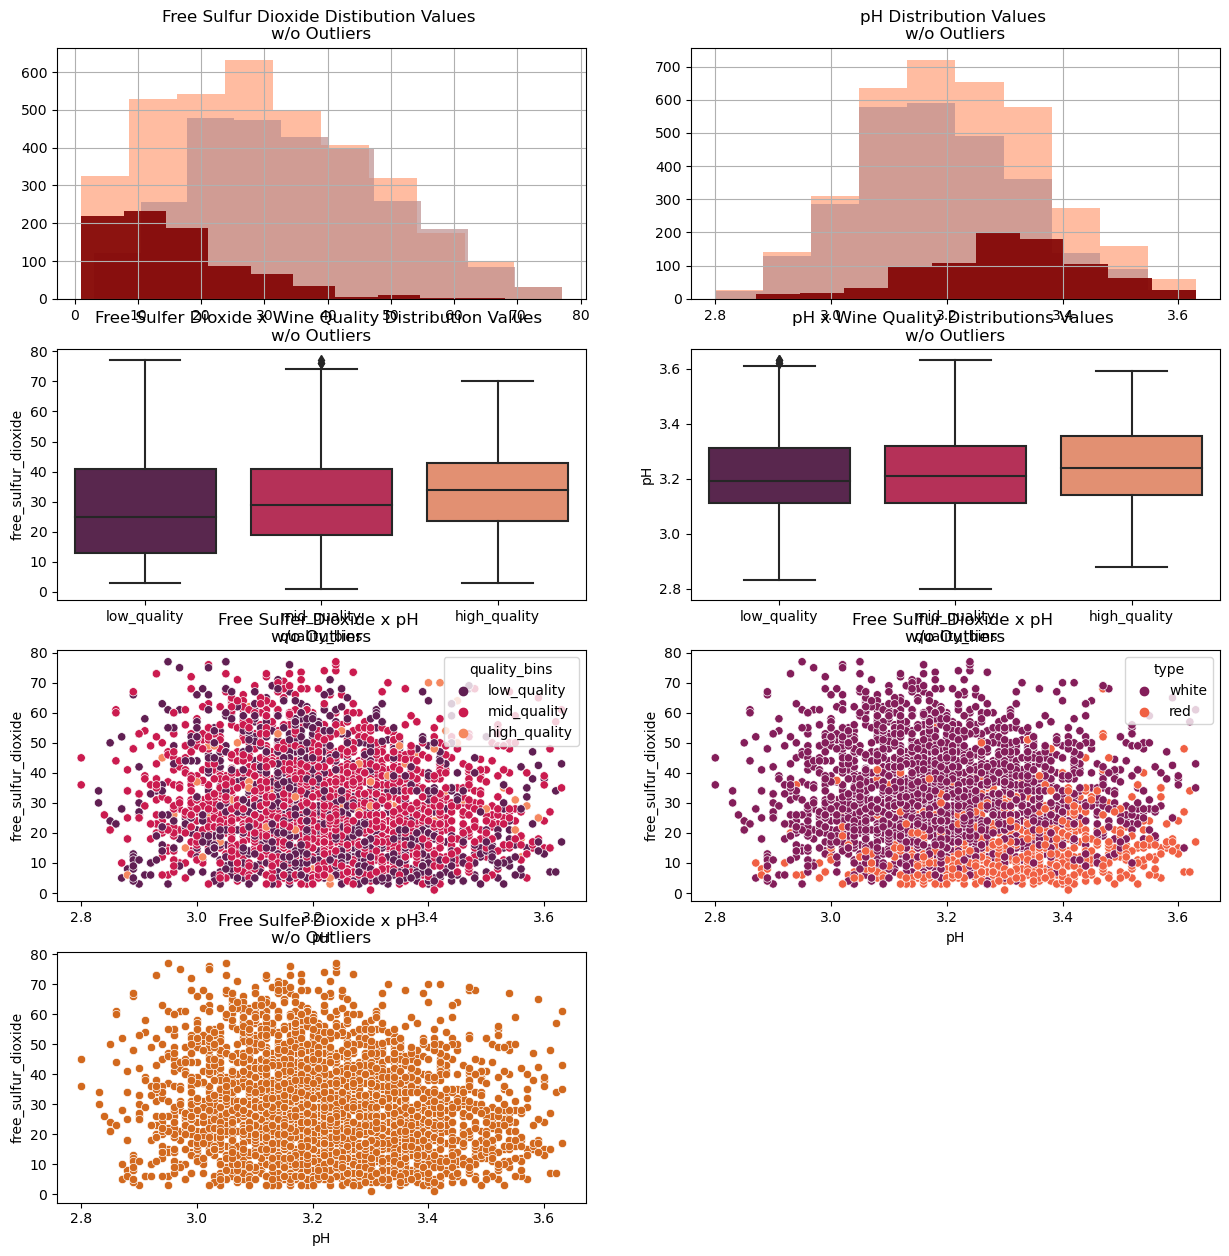

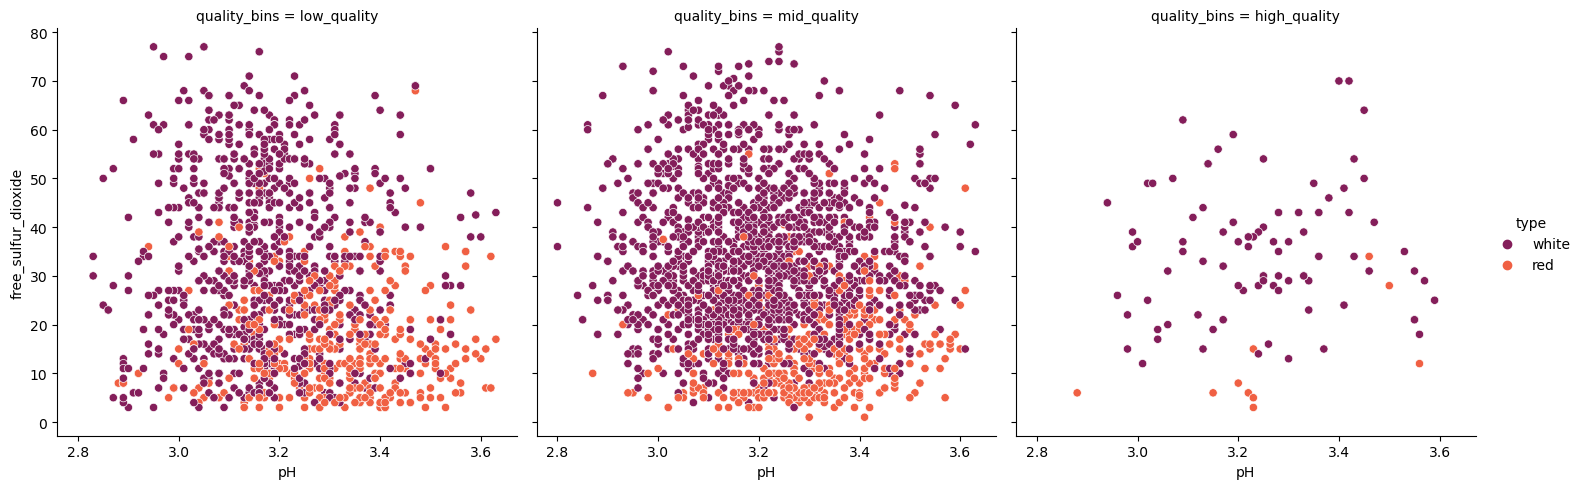

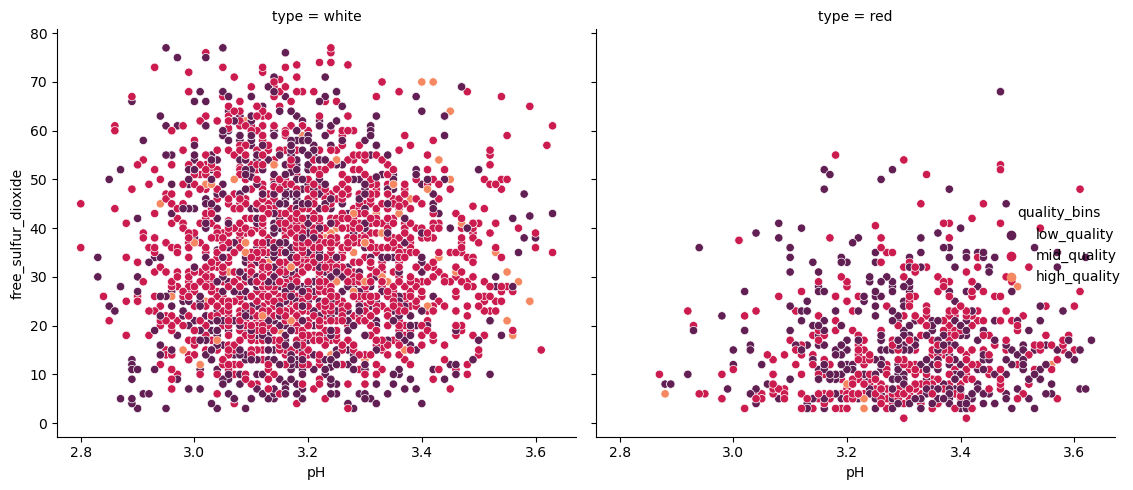

Free Sulfur Dioxide Min Value: 1.0
Free Sulfur Dioxide Max Value: 77.0
--------------------------------------------------
pH Min Value: 2.8
pH Max Value: 3.63


In [20]:
wine_visuals.fsd_x_ph_wo_outliers(train)

In [21]:
# cross tab of free sulfur dioxide x pH
observed = pd.crosstab(train.free_sulfur_dioxide, train.pH)
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between Free Sulfur Dioxide quality and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between Free Sulfur Dioxide quality and pH')

We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between Free Sulfur Dioxide quality and pH.


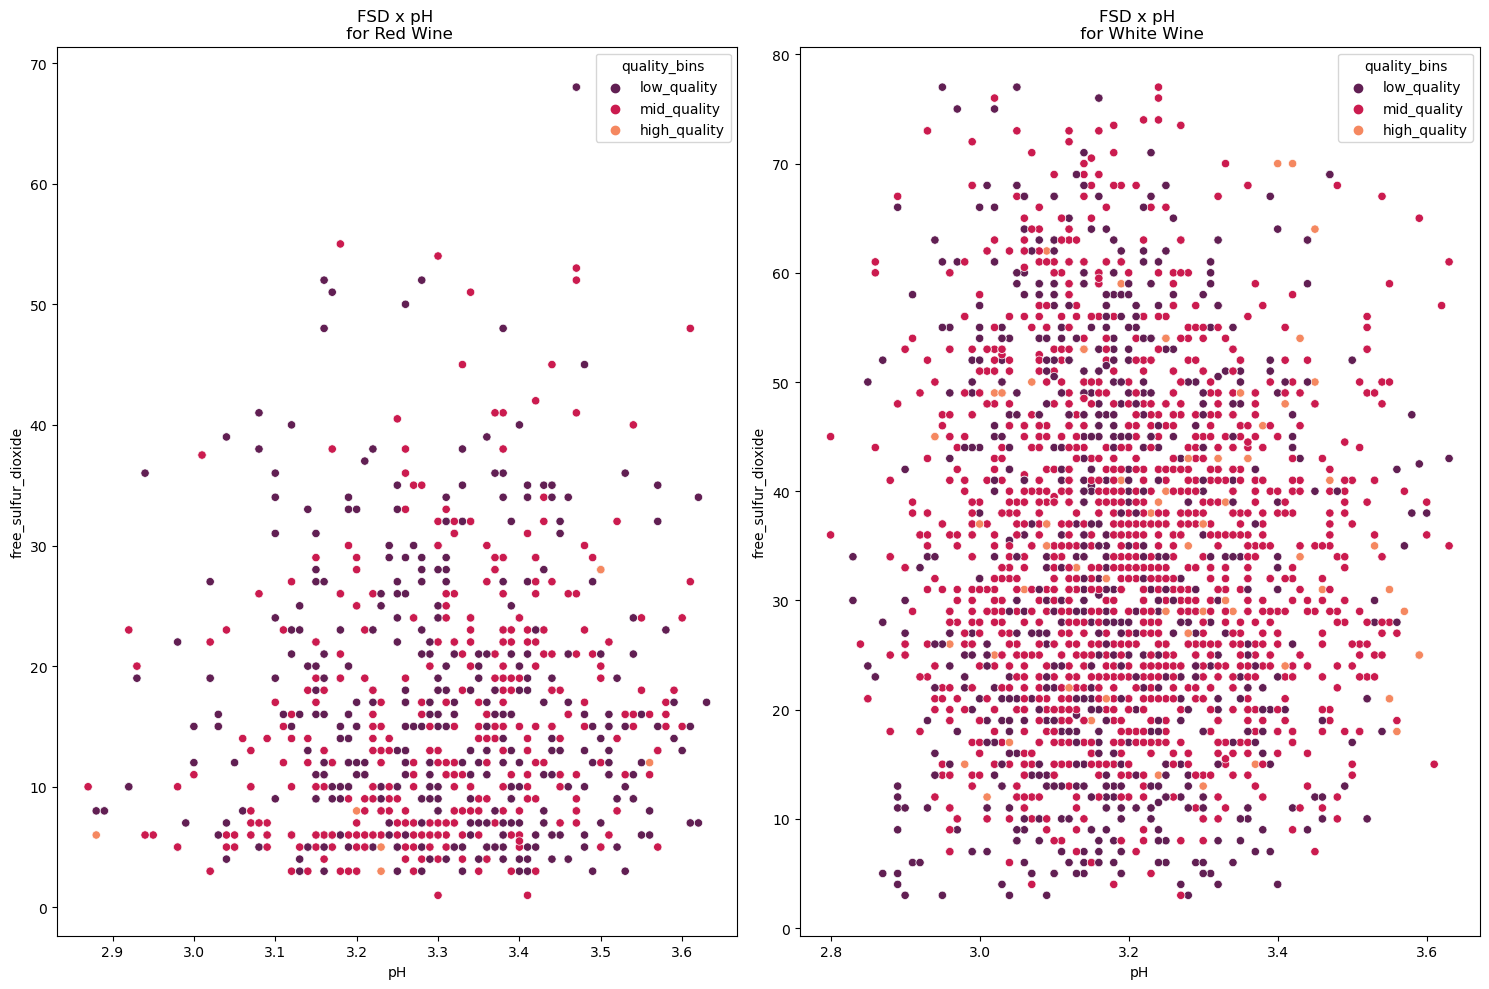

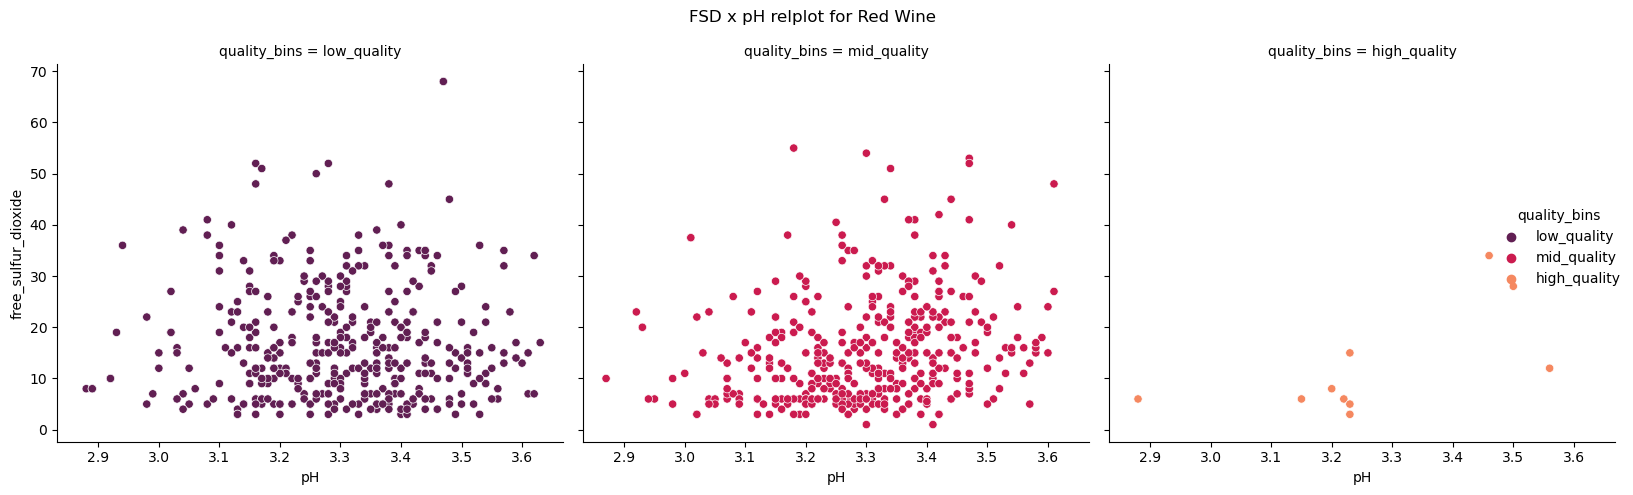

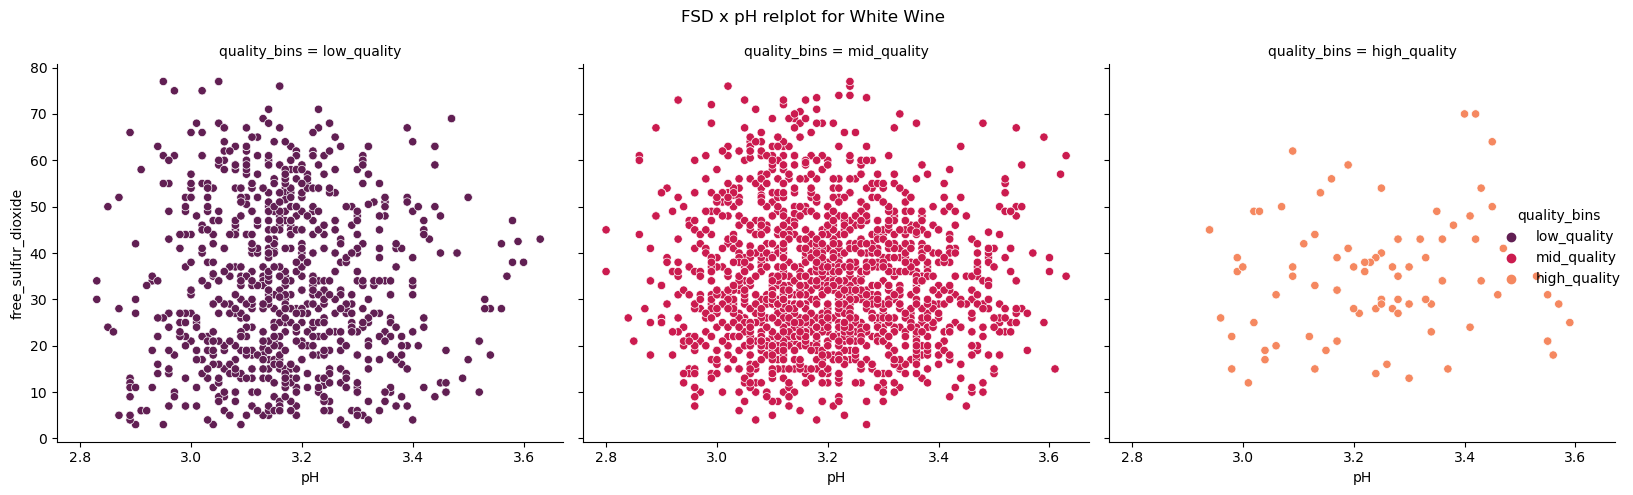

In [22]:
wine_visuals.rw_fsd_x_ph(train)

##### Take aways
- White wines do not seem to have a clear correlation between free sulfur dioxide, pH, and quality.
- Larger pH range for red wine
- Larger FSD range for white wine

In [23]:
# hypothesis test for red wine free sulfur dioxide x pH
# red wine cross tab
observed_red = pd.crosstab(train[train['type']=='red'].free_sulfur_dioxide, train[train['type']=='red'].pH)
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed_red)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between red wine free sulfur dioxide and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between red wine free sulfur dioxide and pH')

We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between red wine free sulfur dioxide and pH.


In [24]:
# hypothesis test for white wine free sulfur dioxide x pH
# white wine cross tab
observed_w = pd.crosstab(train[train['type']=='white'].free_sulfur_dioxide, train[train['type']=='white'].pH)
# chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed_w)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between white wine free sulfur dioxide and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between white wine free sulfur dioxide and pH')

We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between white wine free sulfur dioxide and pH.


__Low Quality Wine x FSD x pH__

H$_0$: There is no relation between low quality wine, pH, and sulfer dioxide.

H$_a$: There is a relation between low quality wine, pH, and sulfer dioxide.

In [25]:
# low quality x FSD x ph
# assign variables for pearsons r
x = train[train['quality_bins'] == 'low_quality'].free_sulfur_dioxide
y = train[train['quality_bins'] == 'low_quality'].pH
# do the thing
corr, p = stats.pearsonr(x,y)
# print corr and p
print(f'p-Value: {p}')
print('-'*50)
print(f'corr Value: {corr}')
print('-'*50)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between low quality wine, free sulfur dioxide, and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between low quality wine, free sulfur dioxide, and pH.')

p-Value: 8.300087897572575e-11
--------------------------------------------------
corr Value: -0.1785875020461815
--------------------------------------------------
We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between low quality wine, free sulfur dioxide, and pH.


__Take away__: 
The relationship between free dulfur dioxide, pH, and low quality wine is significant, but does not have a strong correlation.

__Mid Quality Wine x FSD x pH__

H$_0$: There is no relation between mid quality wine, pH, and sulfer dioxide.

H$_a$: There is a relation between mid quality wine, pH, and sulfer dioxide.

In [26]:
# mid quality x FSD x ph
# assign variables for pearsons r
x = train[train['quality_bins'] == 'mid_quality'].free_sulfur_dioxide
y = train[train['quality_bins'] == 'mid_quality'].pH
# do the thing
corr, p = stats.pearsonr(x,y)
# print corr and p
print(f'p-Value: {p}')
print('-'*50)
print(f'corr Value: {corr}')
print('-'*50)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between mid quality wine, free sulfur dioxide, and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between mid quality wine, free sulfur dioxide, and pH.')

p-Value: 3.271299687615029e-10
--------------------------------------------------
corr Value: -0.1350106630274664
--------------------------------------------------
We reject the null hypothesis. With p value: 0.0000, there is enough evidence to support a statistical relationship between mid quality wine, free sulfur dioxide, and pH.


__Take away__: 
The relationship between free dulfur dioxide, pH, and MID quality wine is significant, but does not have a strong correlation.

__High Quality Wine x FSD x pH__

H$_0$: There is no relation between high quality wine, pH, and sulfer dioxide.

H$_a$: There is a relation between high quality wine, pH, and sulfer dioxide.

In [27]:
# high quality x FSD x ph
# assign variables for pearsons r
x = train[train['quality_bins'] == 'high_quality'].free_sulfur_dioxide
y = train[train['quality_bins'] == 'high_quality'].pH
# do the thing
corr, p = stats.pearsonr(x,y)
# print corr and p
print(f'p-Value: {p}')
print('-'*50)
print(f'corr Value: {corr}')
print('-'*50)
# hypothesis statement
if p < α:
    print(f'We reject the null hypothesis. With p value: {p:.4f}, there is enough evidence to support a statistical relationship between high quality wine, free sulfur dioxide, and pH.')
else:
    print(f'We fail to reject the null hypothesis. With p value: {p:.4f}, this is not enough evidence to support a statistical relationship between high quality wine, free sulfur dioxide, and pH.')

p-Value: 0.5703994463345325
--------------------------------------------------
corr Value: 0.055467988039777816
--------------------------------------------------
We fail to reject the null hypothesis. With p value: 0.5704, this is not enough evidence to support a statistical relationship between high quality wine, free sulfur dioxide, and pH.


__Take away__: 
The relationship between free dulfur dioxide, pH, and MID quality wine is NOT significant and does not have a strong correlation.

#### Take aways
Free sulfur dioxide and pH have a significant relationship to low and mid quality wines but do not have a significant relationship to high quality wines.

    - The dataset for high quality wines is small. I wonder if we need more data to see a significant relationship.
    
    - There may be a relationship to FSD, pH, high wine quality and wine type.

## Clustering for all wine

In [10]:
df, kmean = cluster.clusters(train, 'quality', 'alcohol')
df

quality  alcohol  cluster
2099      6.0     9.50        0
3941      8.0    12.30        1
3840      5.0     9.40        2
24        6.0     9.70        0
2541      7.0    10.00        0
...       ...      ...      ...
1488      5.0    11.40        1
750       5.0     9.50        2
6469      7.0    11.45        1
3581      8.0     8.90        0
490       6.0    10.60        0

[3637 rows x 3 columns]

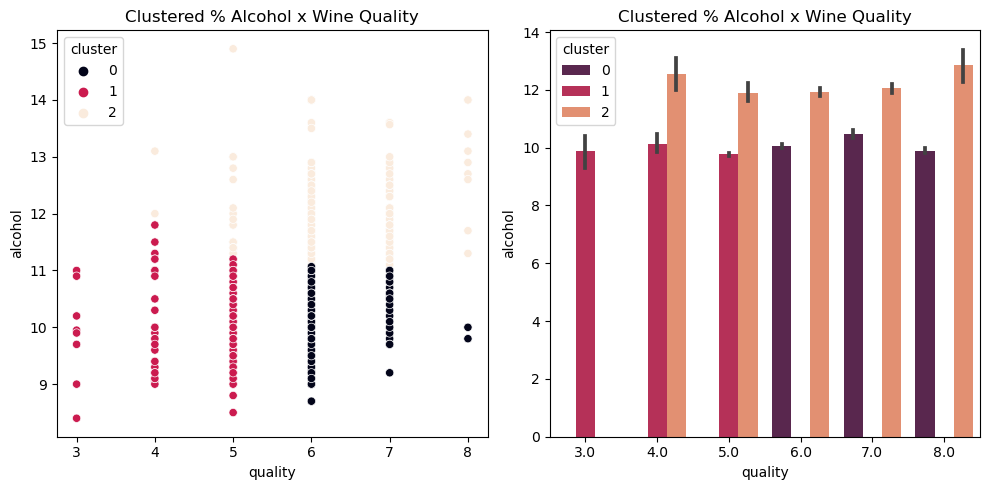

In [9]:
cluster.cluster_vis(df)

In [11]:
centroids = pd.DataFrame(kmean.cluster_centers_, columns=['quality', 'percent_alc'])
print('Centroids Coordinates:')
centroids

Centroids Coordinates:


quality  percent_alc
0  6.195670     9.889925
1  6.412898    11.940346
2  4.882448     9.717821

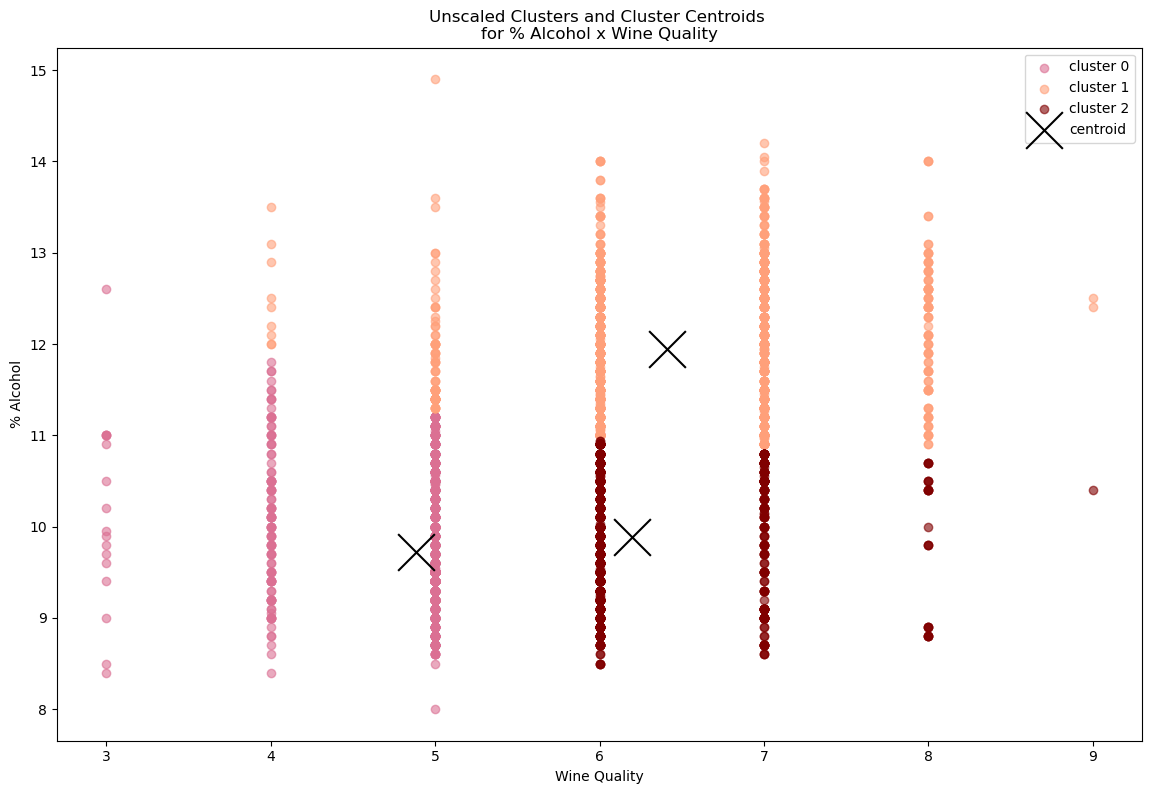

In [12]:
cluster.centroid_cluster(df)

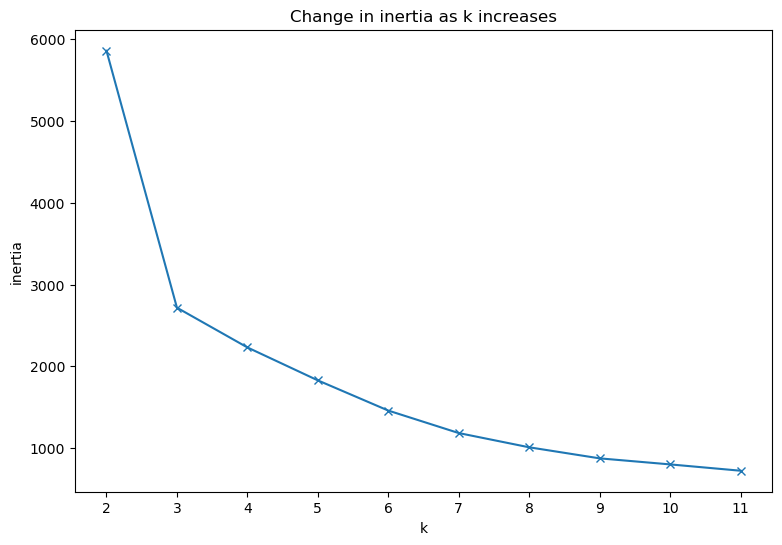

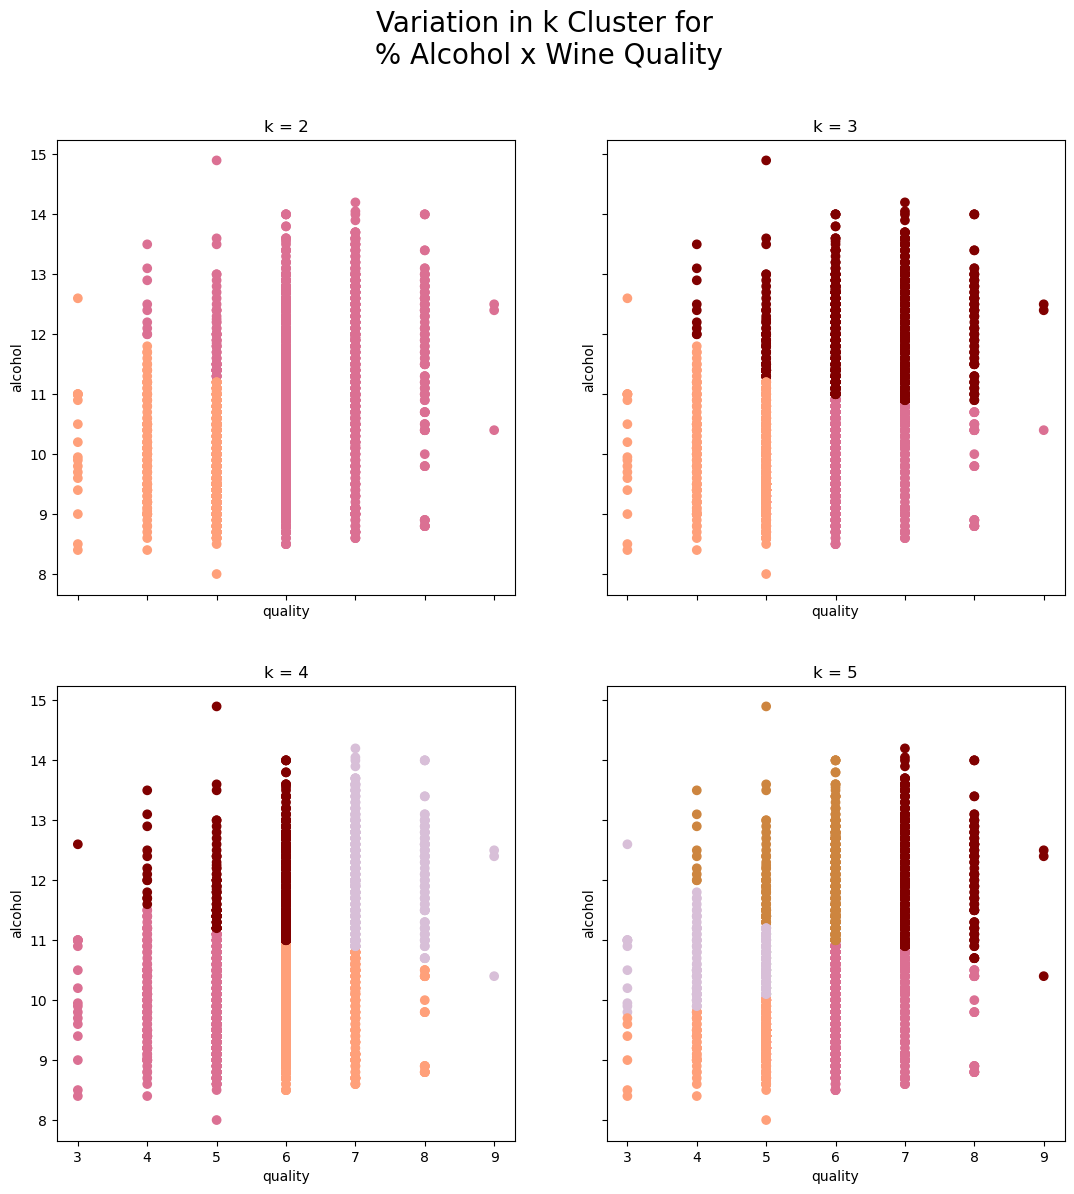

In [13]:
cluster.inertia_change(df)

## Clustering for Red Wine

In [14]:
mask = (train['type'] == 'red')
train_red = train[mask]
df, kmean = cluster.clusters(train_red, 'quality', 'alcohol')


Red Wine Clusters


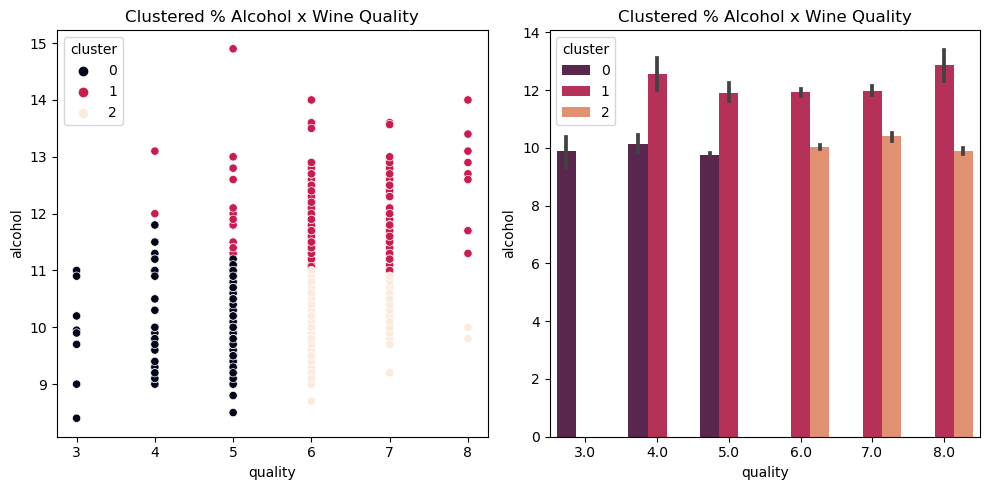

In [15]:
print('\nRed Wine Clusters')
cluster.cluster_vis(df)

In [28]:
centroids = pd.DataFrame(kmean.cluster_centers_, columns=['quality', 'percent_alc'])
print('Centroids Coordinates:')
centroids

Centroids Coordinates:


quality  percent_alc
0  4.881313     9.795328
1  6.285714    11.980635
2  6.141221    10.084606


Red Wine Clusters with Centroids
---------------------------------


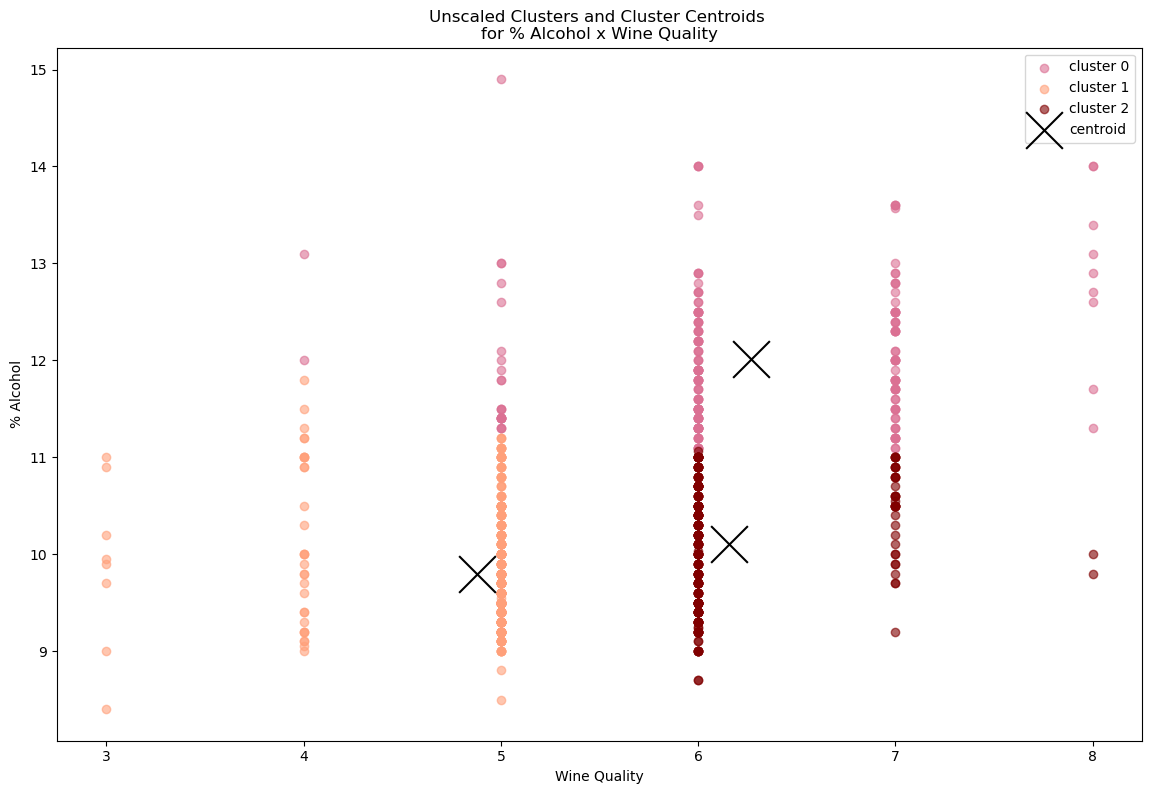

In [16]:
print('\nRed Wine Clusters with Centroids')
print('-'*33)
cluster.centroid_cluster(df)

Red Wine Change in Inertia


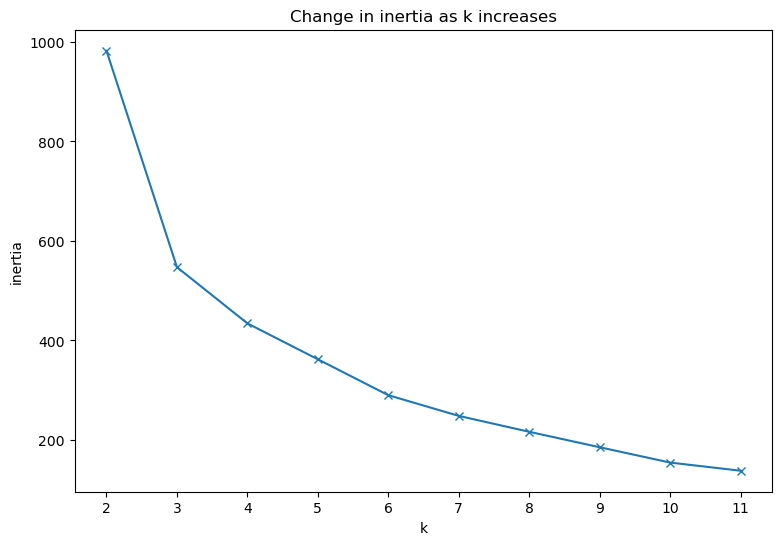

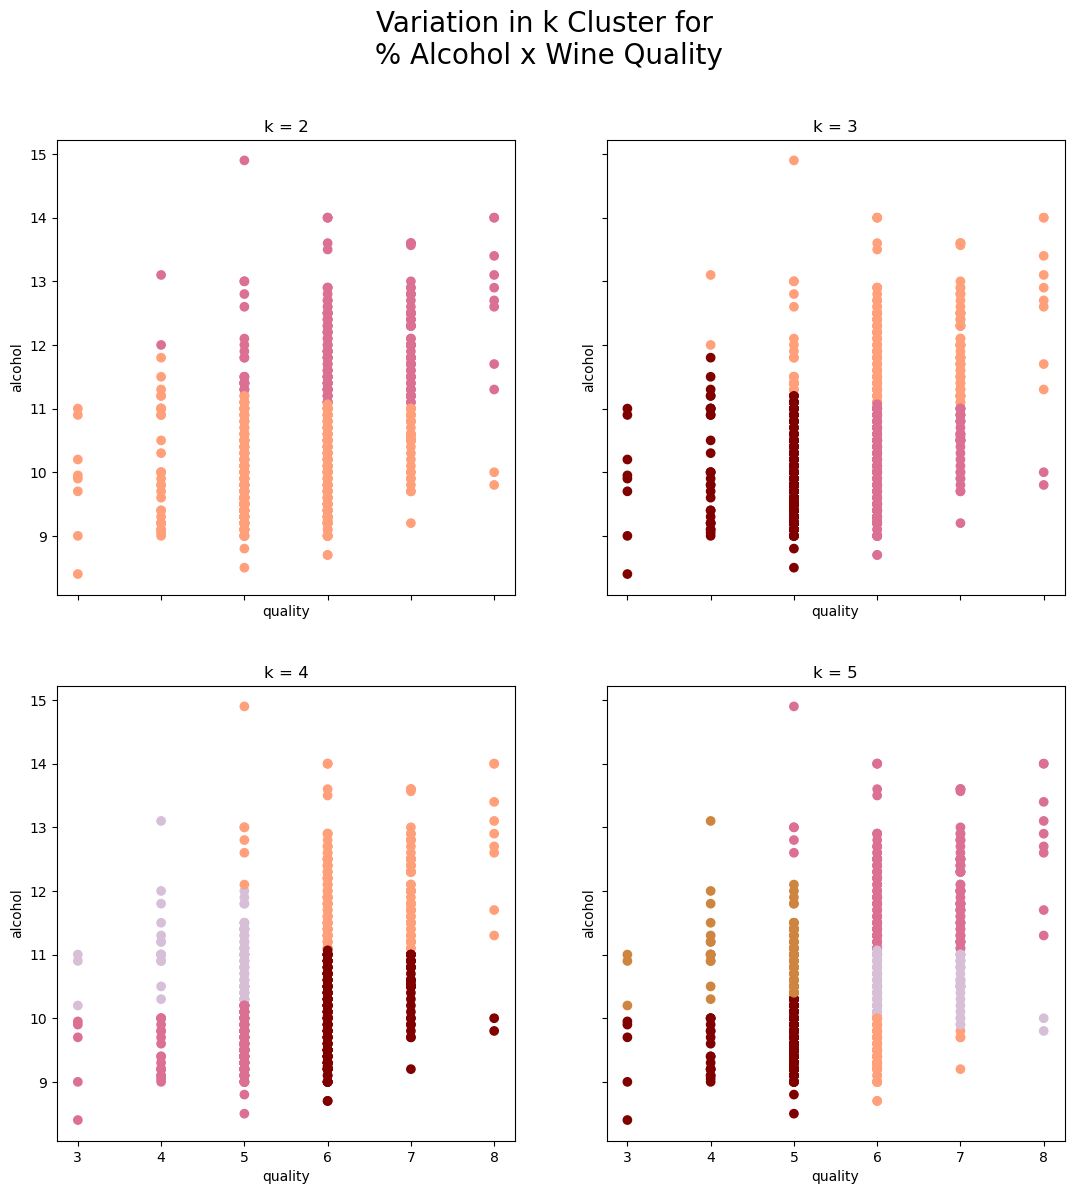

In [17]:
print('Red Wine Change in Inertia')
cluster.inertia_change(df)

## White Wine Clustering

In [18]:
mask = (train['type'] == 'white')
train_white = train[mask]
df, kmean = cluster.clusters(train_white, 'quality', 'alcohol')


White Wine Clusters


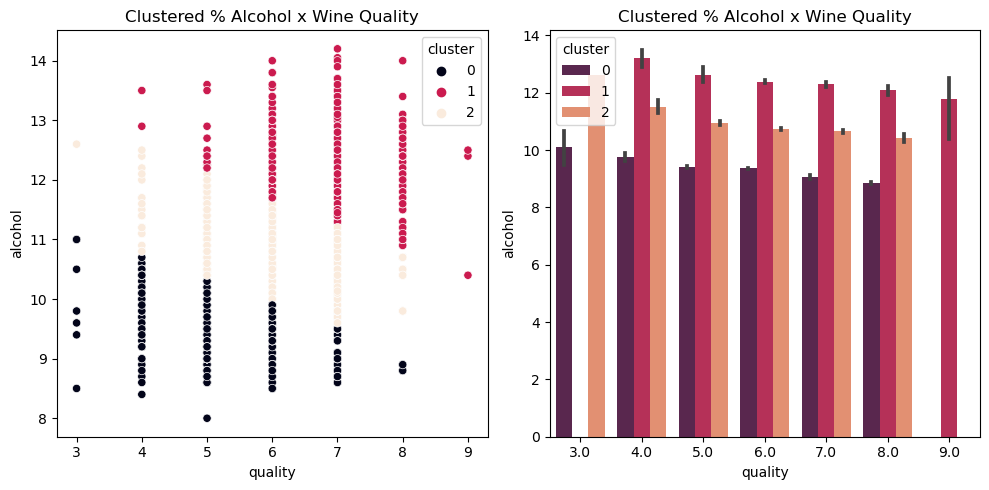

In [19]:
print('\nWhite Wine Clusters')
cluster.cluster_vis(df)

In [20]:
centroids = pd.DataFrame(kmean.cluster_centers_, columns=['quality', 'percent_alc'])
print('Centroids Coordinates:')
centroids

Centroids Coordinates:


quality  percent_alc
0  5.410278     9.388514
1  6.667717    12.307150
2  5.959873    10.779145


White Wine Clusters with Centroids
---------------------------------


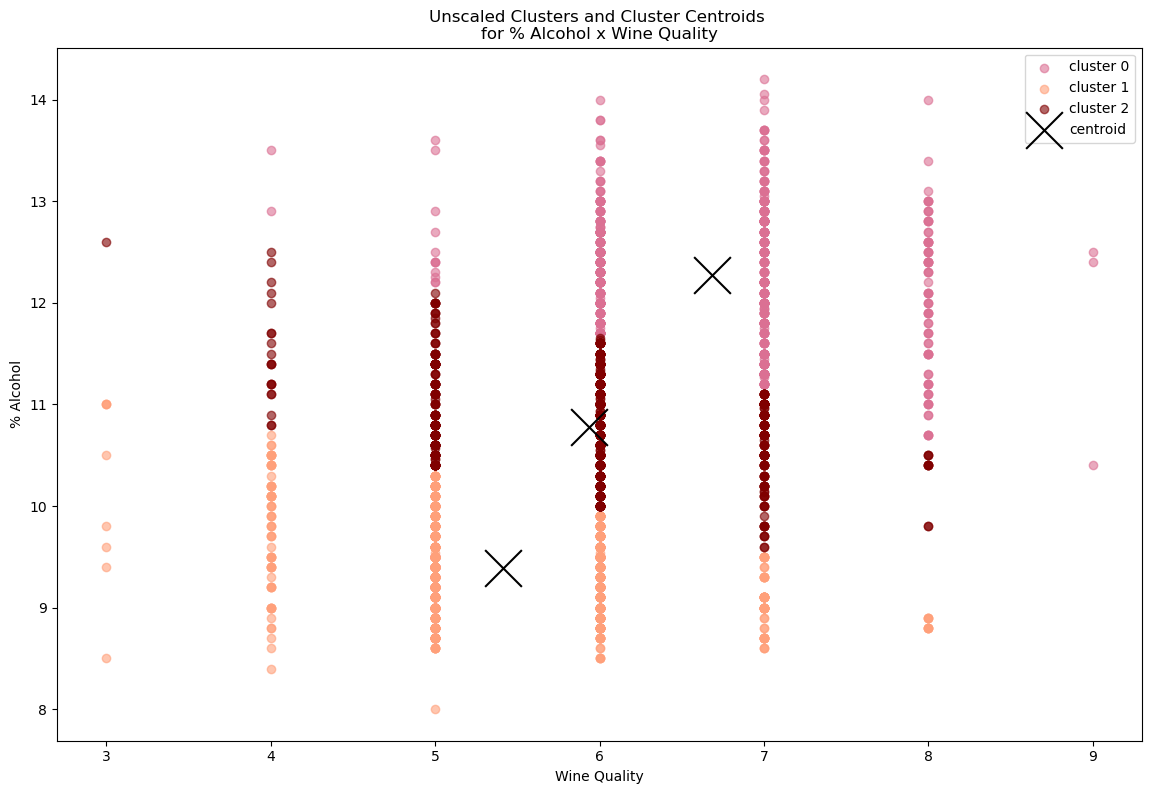

In [21]:
print('\nWhite Wine Clusters with Centroids')
print('-'*33)
cluster.centroid_cluster(df)

White Wine Change in Inertia
---------------------------------


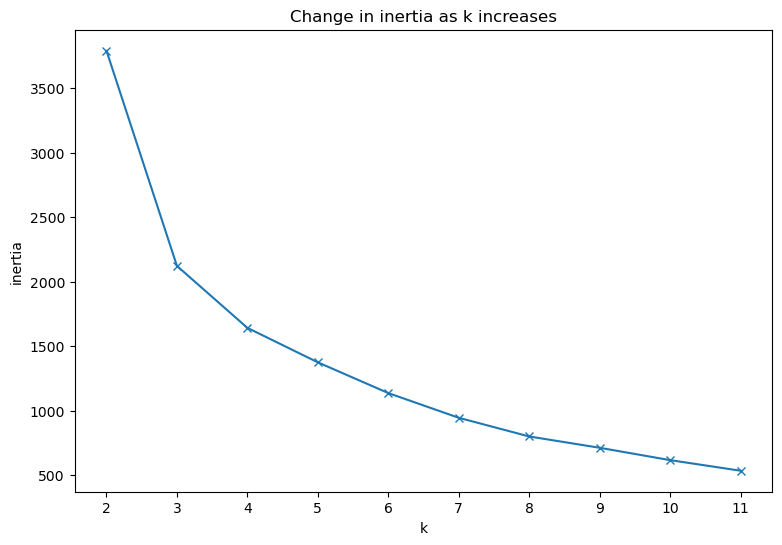

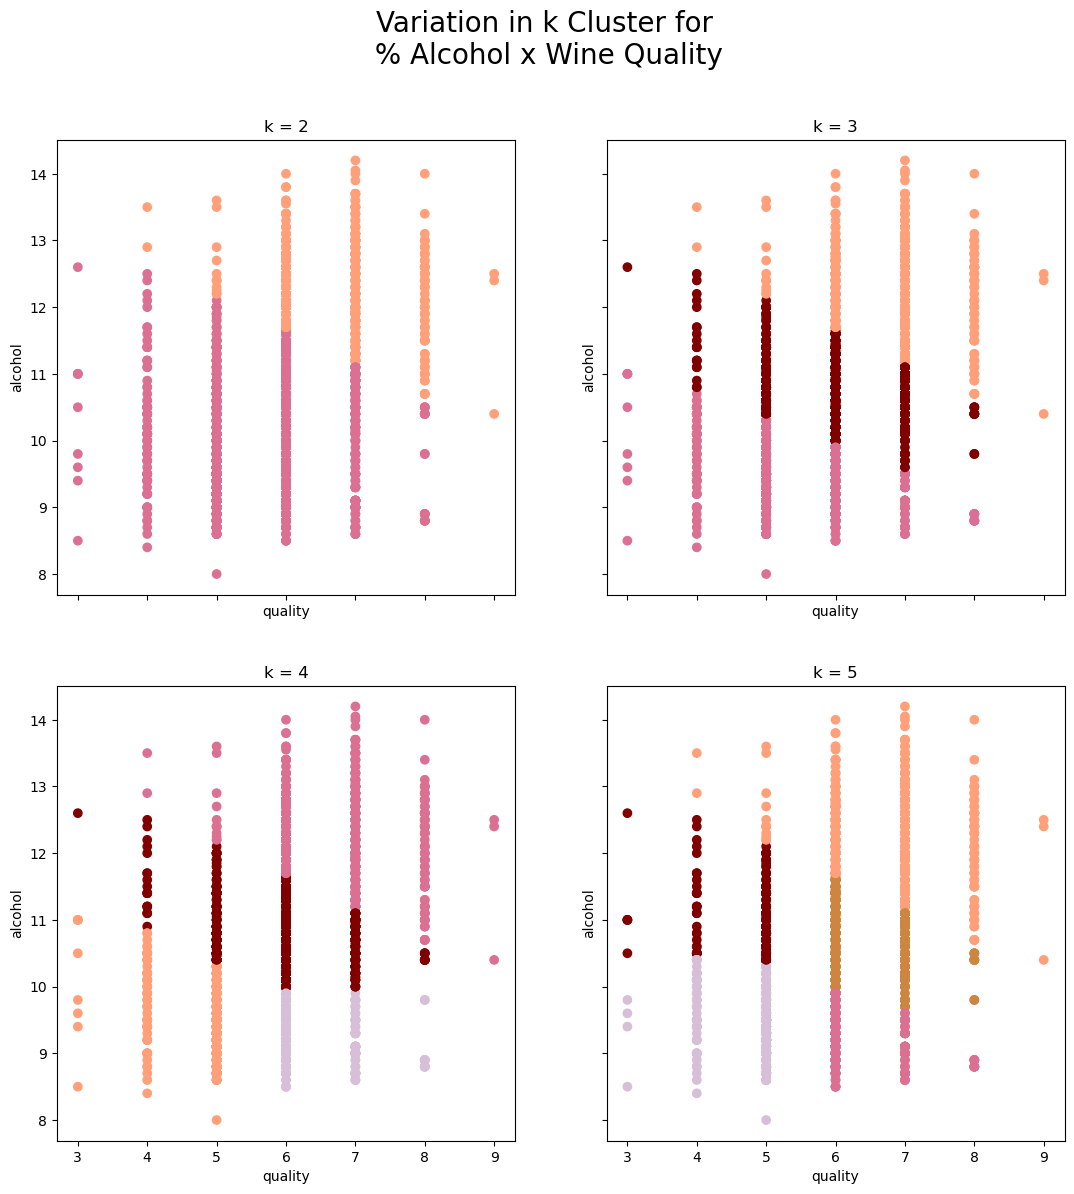

In [22]:
print('White Wine Change in Inertia')
print('-'*33)
cluster.inertia_change(df)